# What happens in this notebook

 - [1] Load all the EEMD selected signals from WT_X
 - [2] Rectify and LP all these signals
 - [3] Generate features from TIME, FREQUENCY and POWER SPECTRUM and concat into one DF
 - [ ] Cluster this dataset using DBscan, Kmeans or hiarcical clustring
 

In [648]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [649]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os,os.path
ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
%autoreload
from scipy import stats
import glob # To count files in folder
import functions as f
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd,plotting_methods
import resample_signals, filter_signals, plotting_methods,filters,correlation_coeff, feature_extraction,polycoherence,clustering

### Need the raw signal

In [114]:
# need the raw signal
_, times, op_data_intervals, _ = load_raw_signals.load_raw('gearbox','wt04')

File exist


# Rectify and lowpass all signal from WT4 gearbox

In [ ]:
fs=25600
path_folder = '/Volumes/OsvikExtra/signal_data/raw_filtered_6000Hz/gearbox/wt04/eemd_signals/'
highcut_lp = 2000

file_count = len(glob.glob1(path_folder,"*.csv"))
print("file count:", file_count)

final_signals=[]
for i in range(file_count):
    path=path_folder + f'interval_number_{i}.csv'
    df = pd.read_csv(path, header=None)
    s = df.to_numpy()
    rectified = abs(s[1])**2 # 1 this is the signal with the highest correlation!
    bandpass_filtered_rect_lp = filters.butter_lp_filter(rectified, highcut_lp, fs, order=5)
    del rectified
    del df
    final_signals.append(bandpass_filtered_rect_lp) # enveloped signals.

In [533]:
timestamps = times[0][0:20000]

# Bispectrum, for one interval

In [101]:
N = len(sig)
f= N//times[0][20000]
f

25600.0

(20000,)


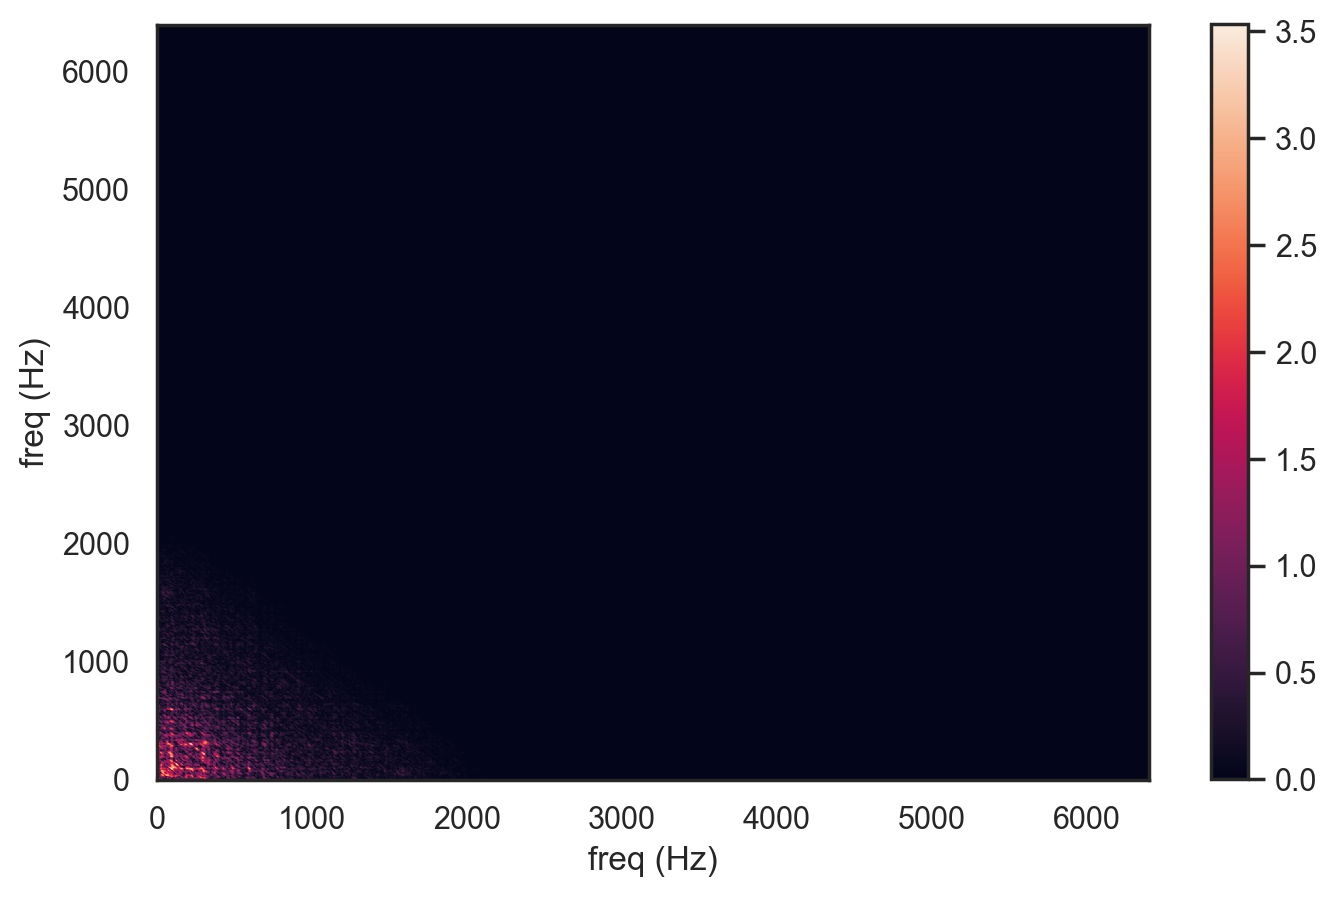

(1875, 1875)


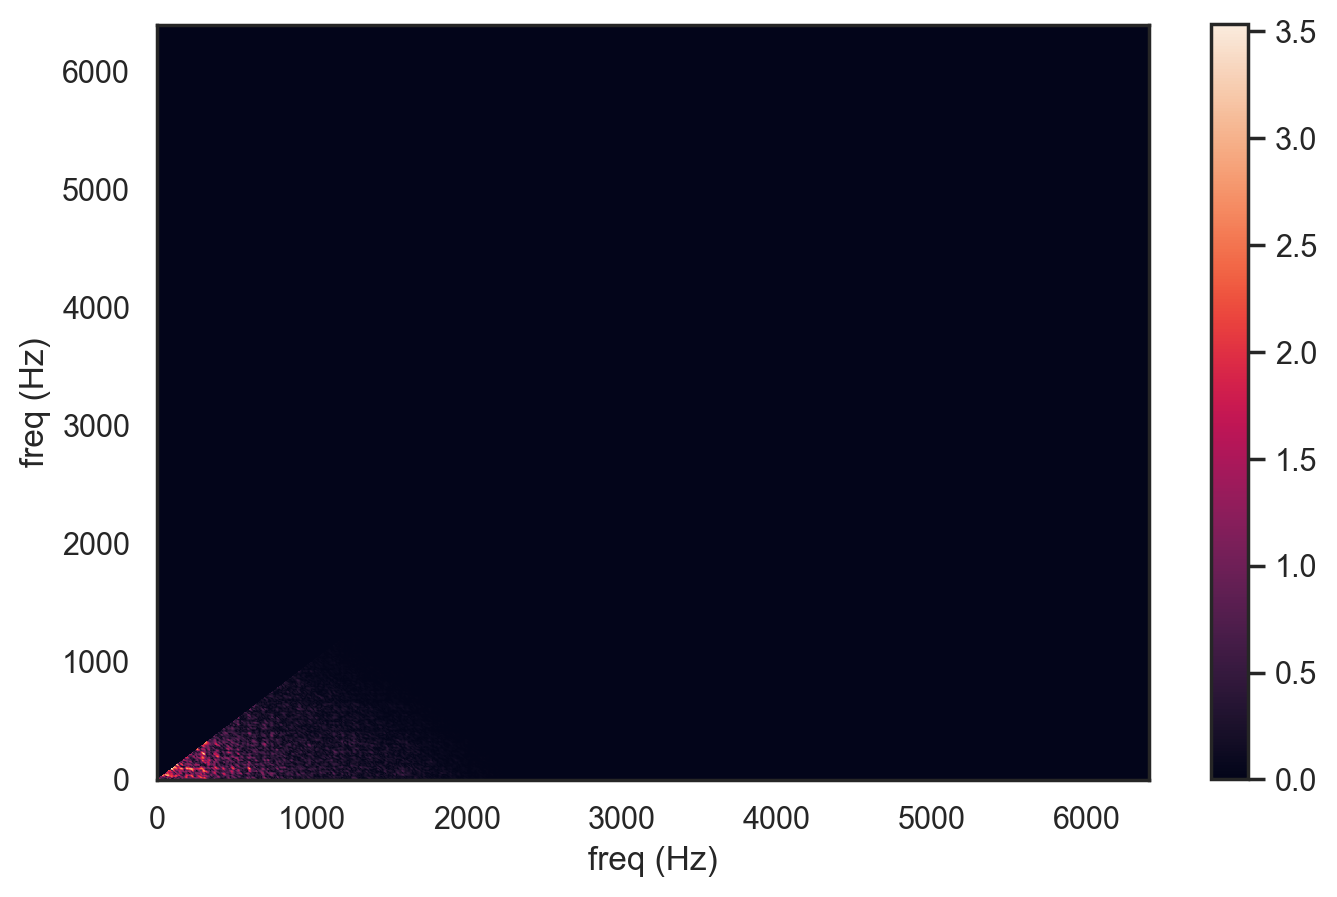

In [534]:
from math import pi
import numpy as np
from numpy.fft import rfftfreq, rfft
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

print(sig.shape) # (20000,)

N=15000 # Select the N to split the signal into N parts
kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
freq1, fre2, bispec = polycoherence.polycoherence(sig, fs, norm=None, **kw)
polycoherence.plot_polycoherence(freq1, fre2, bispec)
plt.show()
print(bispec.shape)

bispec_half = np.triu(bispec) # remove symmetric part
polycoherence.plot_polycoherence(freq1, fre2, bispec_half)
plt.show()

# Extracting features from the final_signals

## The frequency domain features are now:
    1. Sum of logarithmic amplitudes of the bi-spectrum
    2. Sum of logarithmic amplitudes of diagonal elements in the bi-spectrum
    3. First order spectral moment of amplitudes of diagonal elements in the bi spectrum
    4. Normalized bi-spectral entropy, calculate for the whole bispectrum. Same every time        so it won't matter
    5. Normalized bi-specral squared entropy
    6. Weighted center of bi-spectrum

### Time domain features
    1. RMS
    2. Kurtosis
    3. Skewness
    4. Energy mean
    5. Normalized bi-specral squared entropy
    6. Signal mean
### Adding Power Sepectrum density features


In [568]:
feature_df = feature_extraction.generate_feature_df(4,25600, op_data_intervals, final_signals)

Frequency features exist
Filtering done.
Saving all features to file: /Volumes/OsvikExtra/signal_data/raw_filtered_6000Hz/gearbox/wt04/dataset.csv


In [569]:
feature_df

,Index,AvgPower,ActPower,WindSpeed,NacelleDirection,AvgSpeed,rms,kurt,skewness,energy_mean,signal_mean,Power spectral entropy,B1,B2,B3,B4,B5
1,1,2697.461426,2332.100098,9.1,256.100006,1456.464986,22098.519817,6.689281,2.059123,3200.186703,82.552835,0.580794,-43398992.0,-43533.234375,-5.621581e+07,11.709023,130.643858
2,2,2606.151855,2843.500000,10.0,240.199997,1468.503663,18689.689742,6.057600,1.929951,3200.136652,70.474935,0.576439,-45124104.0,-45158.257812,-5.807831e+07,11.736296,128.927151
3,3,2541.849854,2694.100098,10.5,71.099998,1458.875183,18522.538827,5.409207,1.953700,3200.140569,68.435915,0.574164,-44672024.0,-44799.507812,-5.758532e+07,11.711760,128.878041
4,4,2853.304199,3293.399902,12.7,269.399994,1460.635409,16119.262244,4.723323,1.848180,3200.098930,60.964040,0.579481,-45195252.0,-45253.238281,-5.790530e+07,11.770350,134.833451
6,6,2752.077881,3040.300049,9.7,143.899994,1490.140485,22726.360934,5.993032,1.989390,3200.199083,85.946529,0.584168,-43321372.0,-43293.394531,-5.611709e+07,11.779746,142.769424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,417,3138.052002,3203.399902,11.4,293.899994,1504.263633,21814.986070,4.468187,1.733562,3200.180155,83.180350,0.595089,-43992008.0,-44001.664062,-5.693940e+07,11.908980,155.274496
418,418,2579.166504,2568.500000,10.3,266.500000,1469.268894,23474.228477,4.949252,1.858898,3200.222252,87.506121,0.582115,-43517992.0,-43532.750000,-5.644743e+07,11.784130,134.348440
420,420,2891.829346,2819.300049,10.4,318.600006,1487.214505,21450.040203,3.782106,1.603030,3200.172196,82.730113,0.586437,-44202000.0,-44161.007812,-5.709530e+07,11.886208,151.272468
421,421,2581.525879,3160.600098,10.2,317.000000,1489.520070,21543.682855,5.500596,1.880394,3200.176791,81.829277,0.591088,-43902516.0,-44012.574219,-5.688885e+07,11.863752,146.899298


## Pairplots

In [ ]:
'''
*** Plotting the pairplot for all features.

ax=sns.pairplot(feature_df,vars=['ActPower','WindSpeed','NacelleDirection','AvgSpeed','rms','kurt','skewness','signal_mean','Power spectral entropy','B1','B2','B3','B4','B5'],hue='Index',palette='Blues')

norm = plt.Normalize(feature_df.Index.min(), df.Index.max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
ax._legend.remove()
plt.colorbar(sm)

plt.show()

# Getting the features from the time domain as well
sns.pairplot(time)
'''

In [ ]:
'''# sns.pairplot(dfs[0],hue="Index")
sns.set(style="ticks", color_codes=True,palette="Blues")
sns.pairplot(res,vars=['B1','B2','B3','B4','B5'],hue='Index')
# sns.pairplot(dfs[0], hue='Index')
'''

# Clustering

## Clustering on raw signals

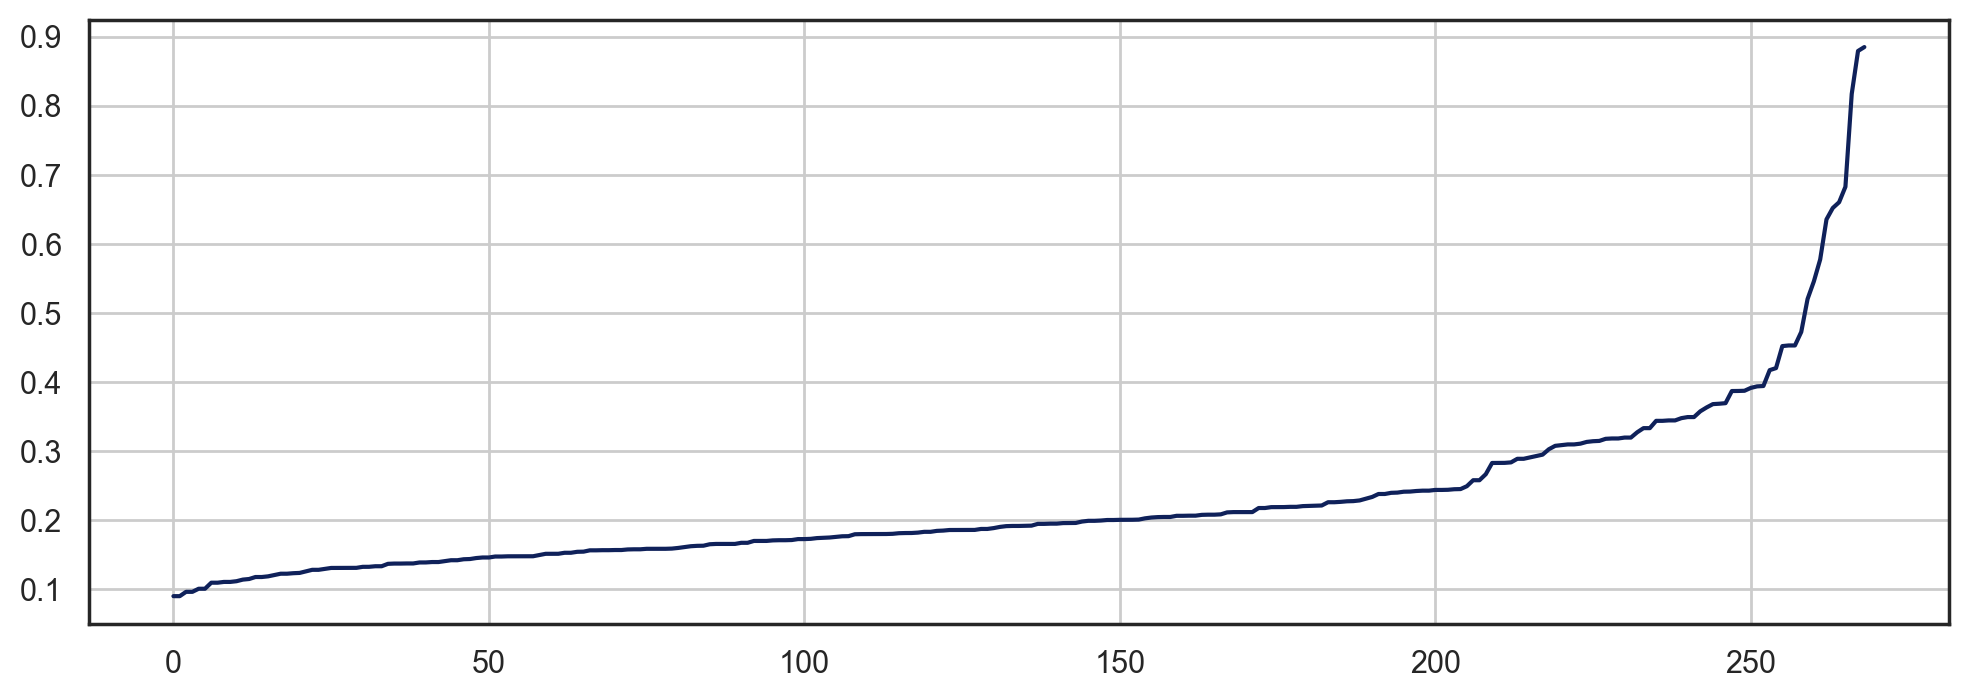

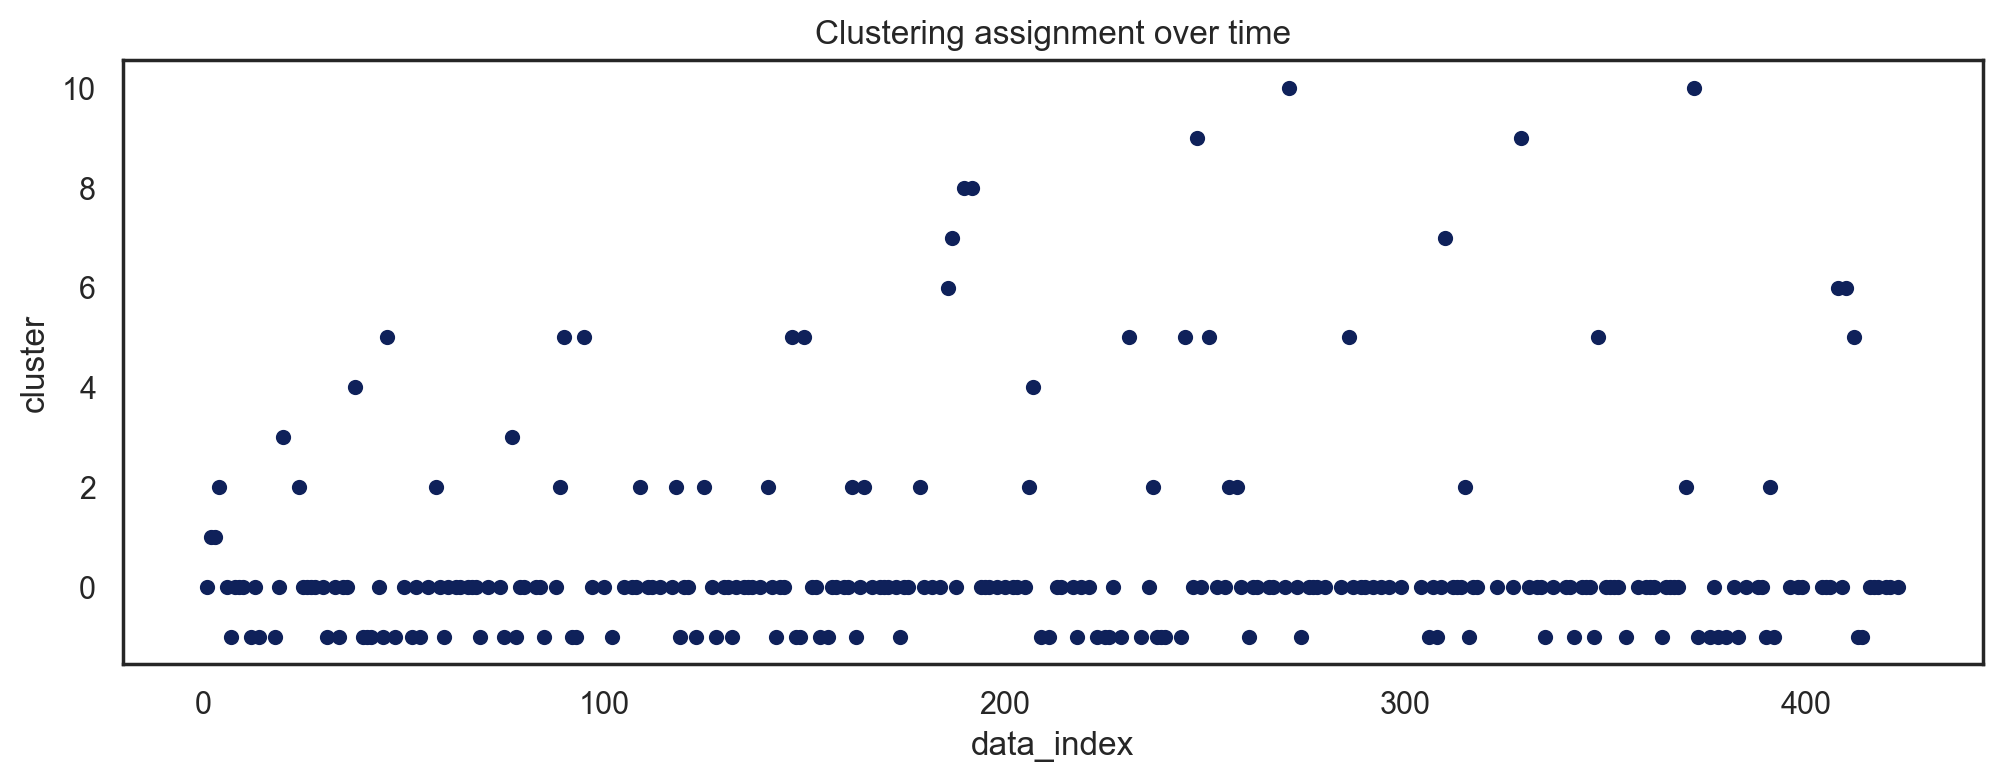

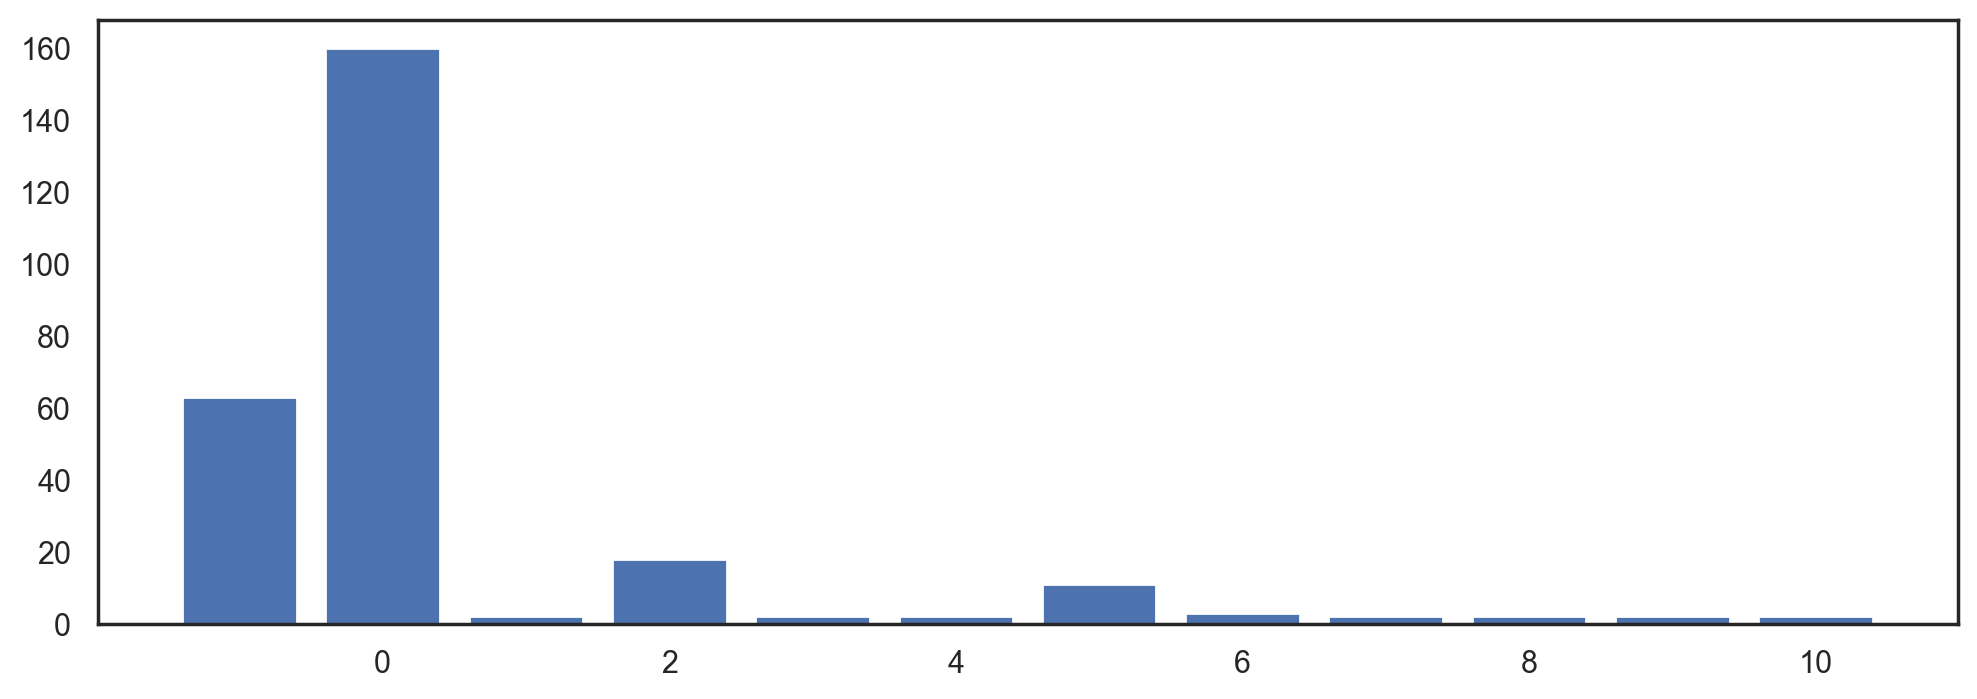

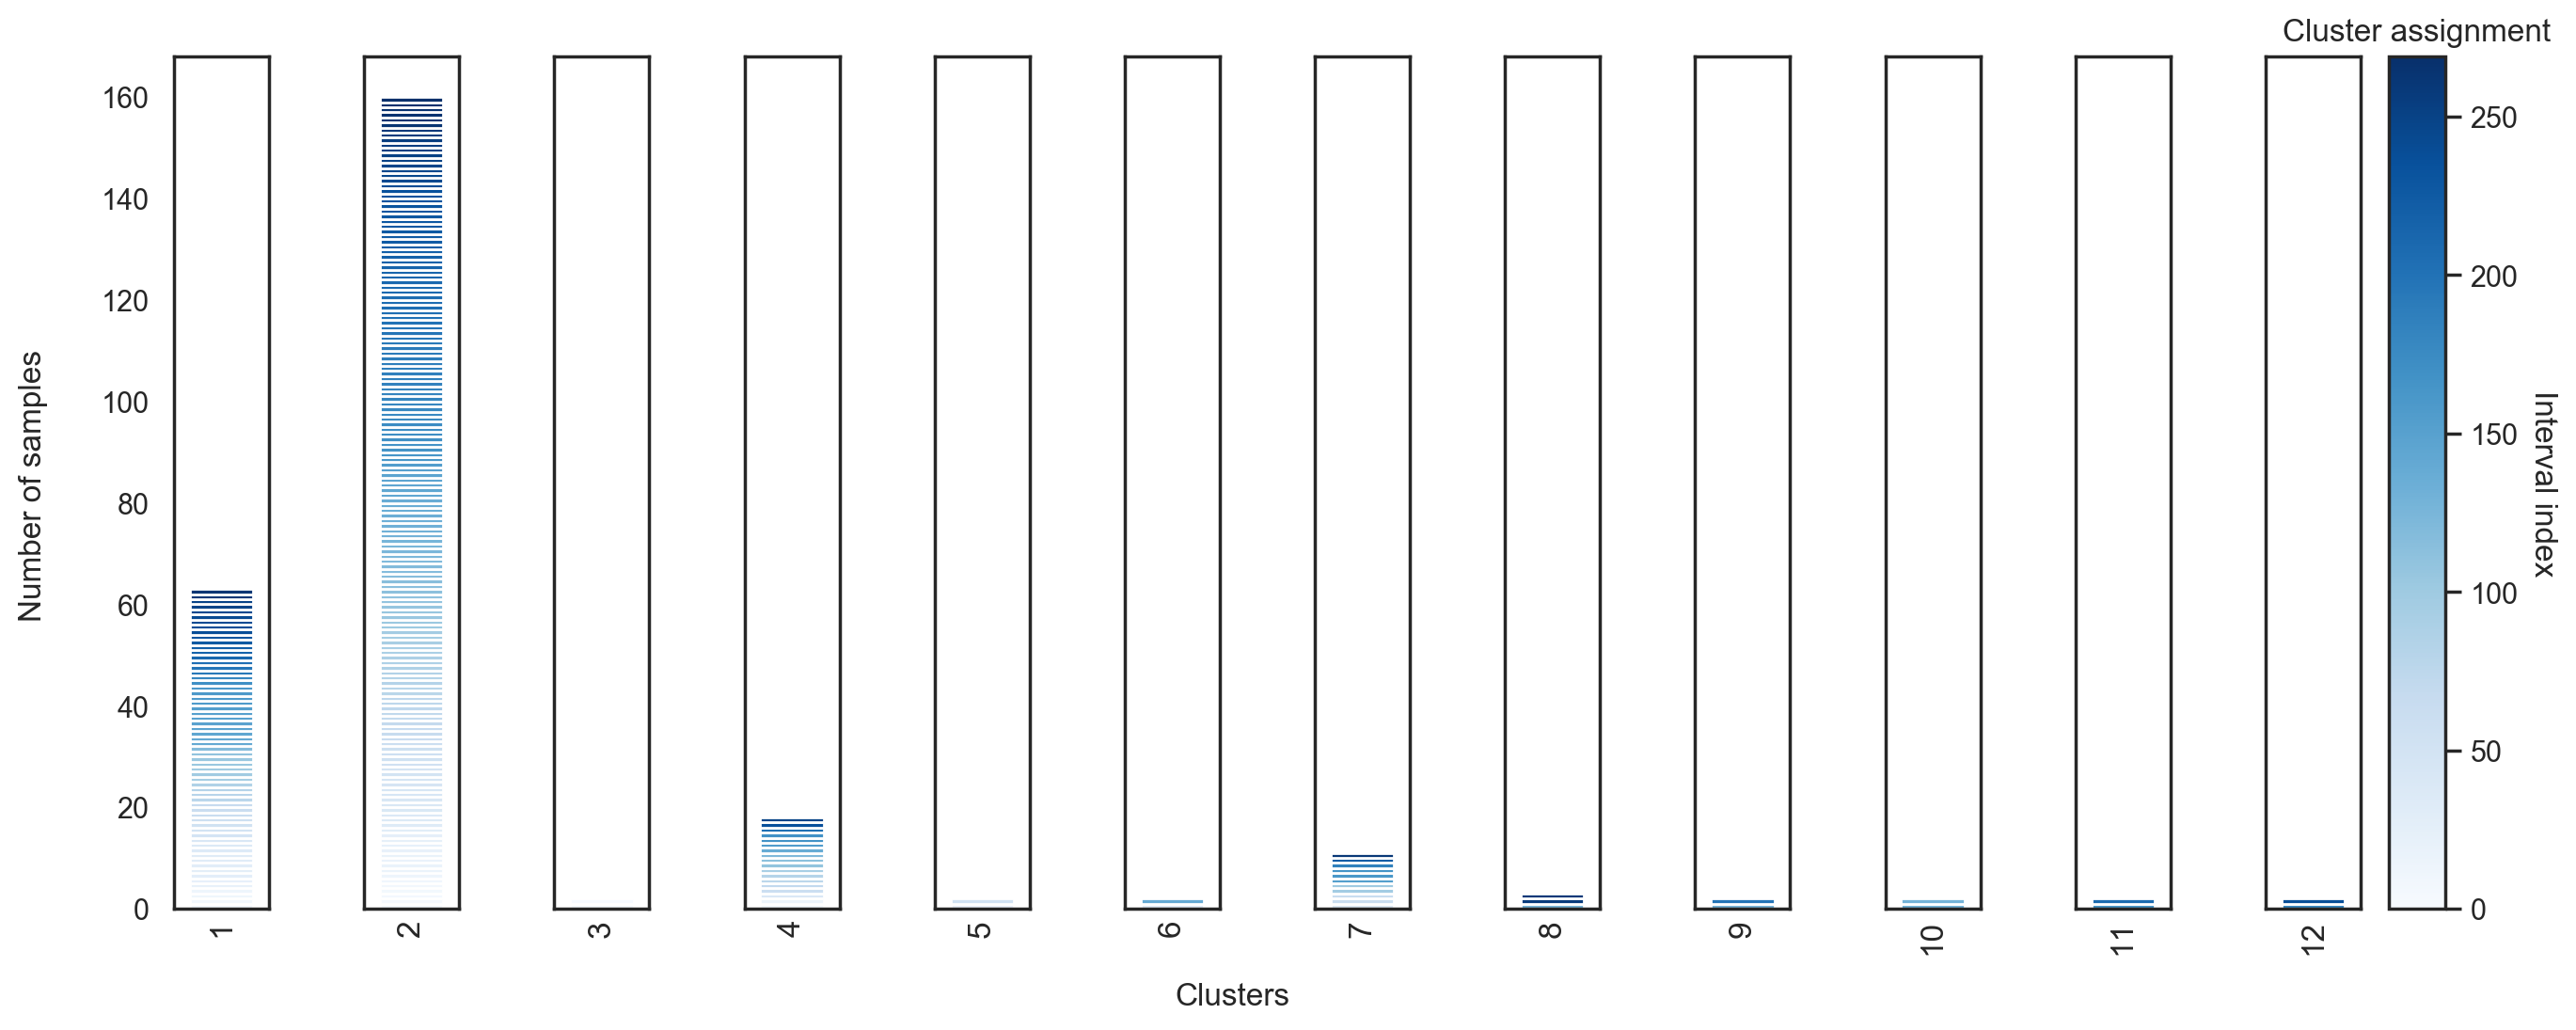

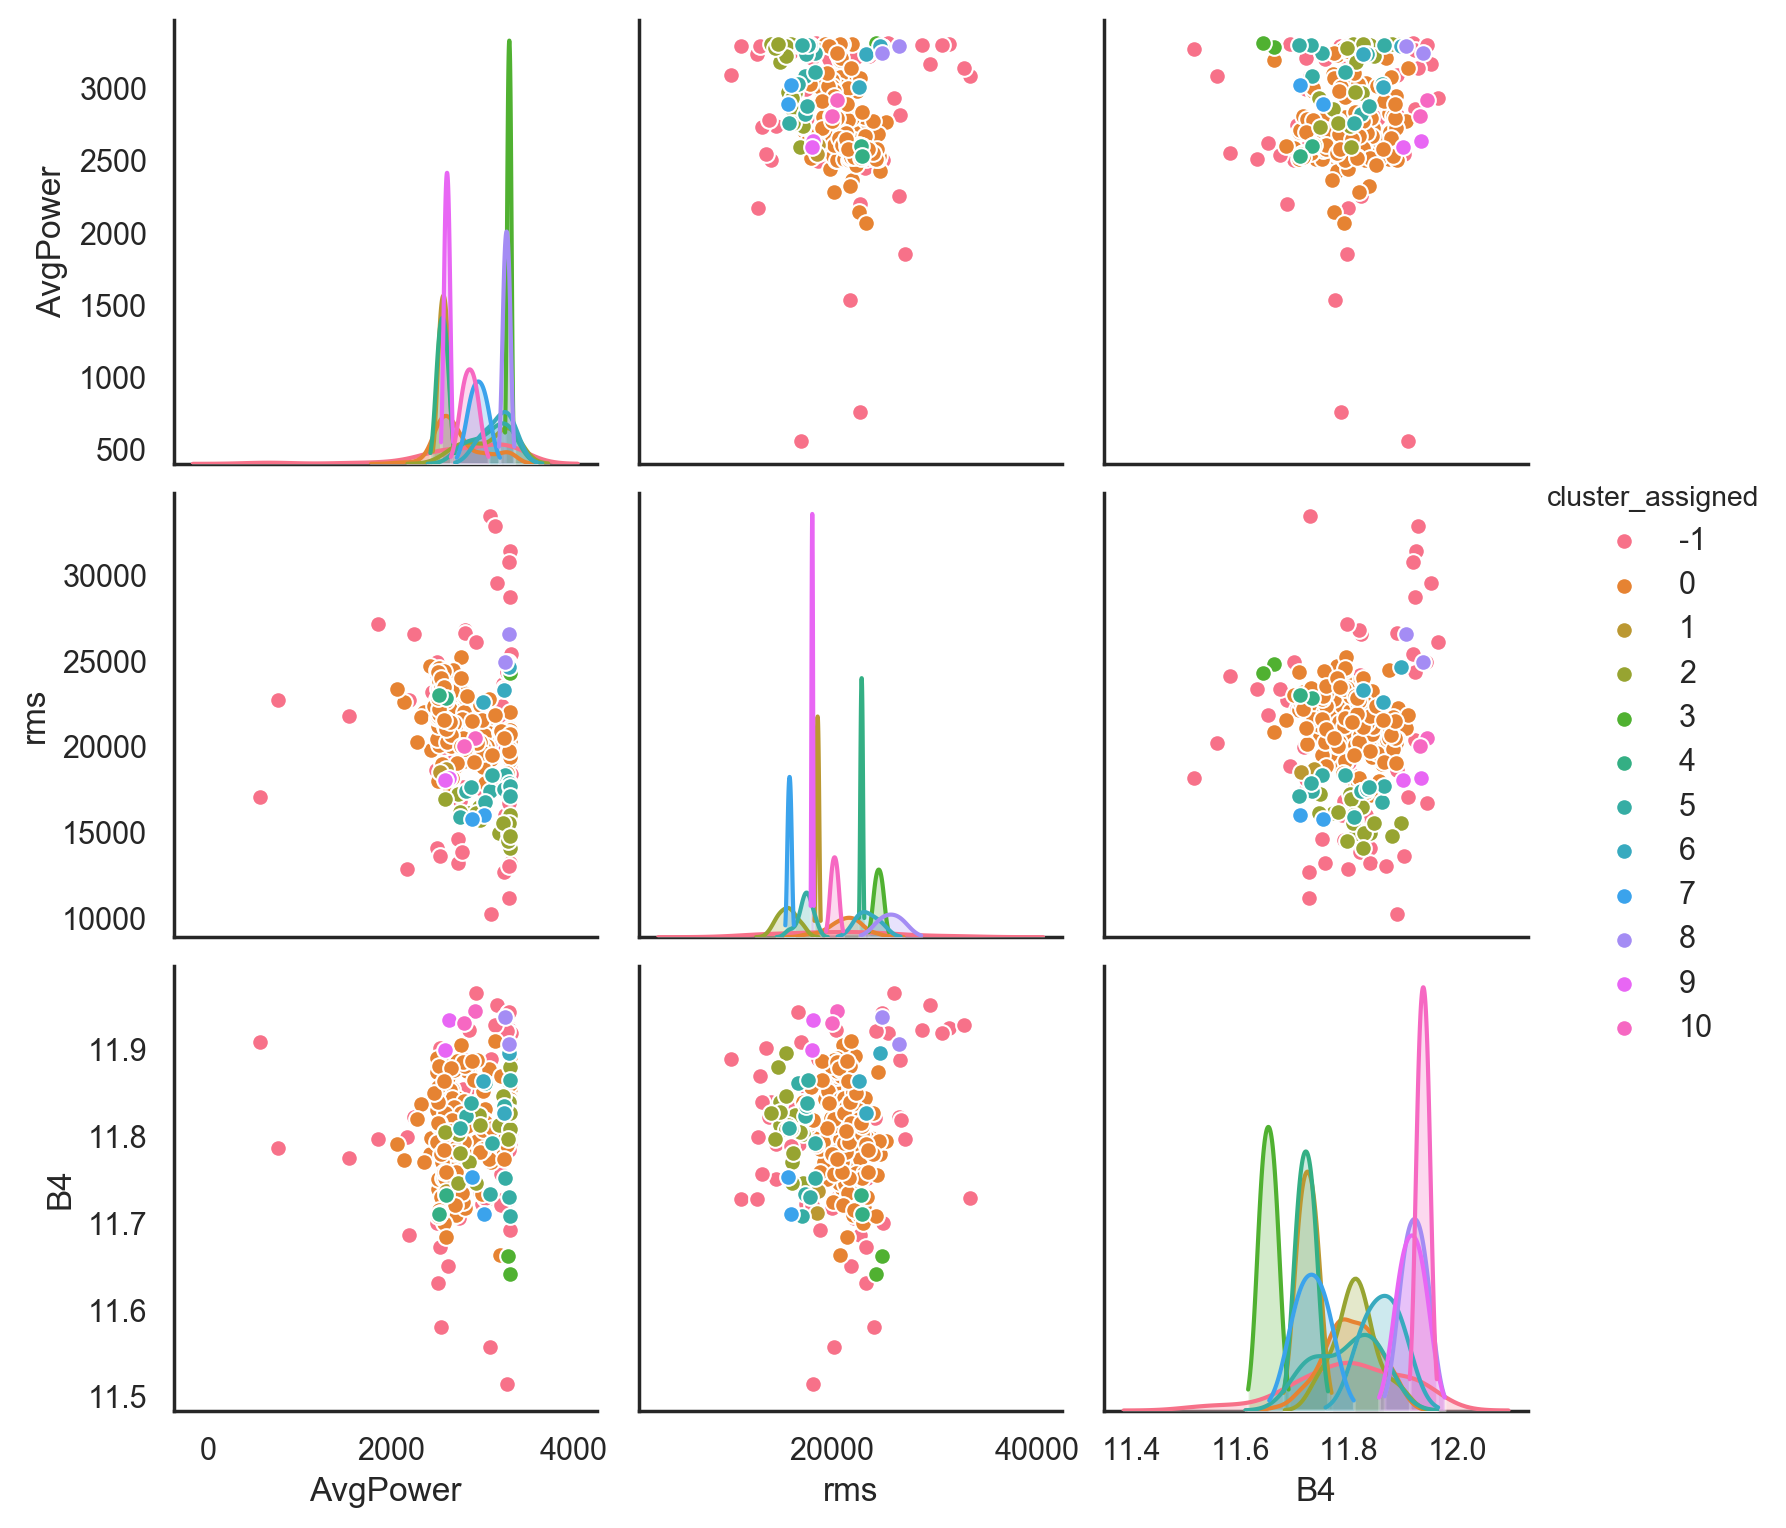

In [645]:
cluster_labels = clustering.db_scan_clustering(feature_df,'raw',eps=0.25)
clustering.plot_clusters(cluster_labels)
clustering.plot_clusters_pair_plot(feature_df, ['AvgPower','rms','B4'],cluster_labels)

## PCA -> DB scan

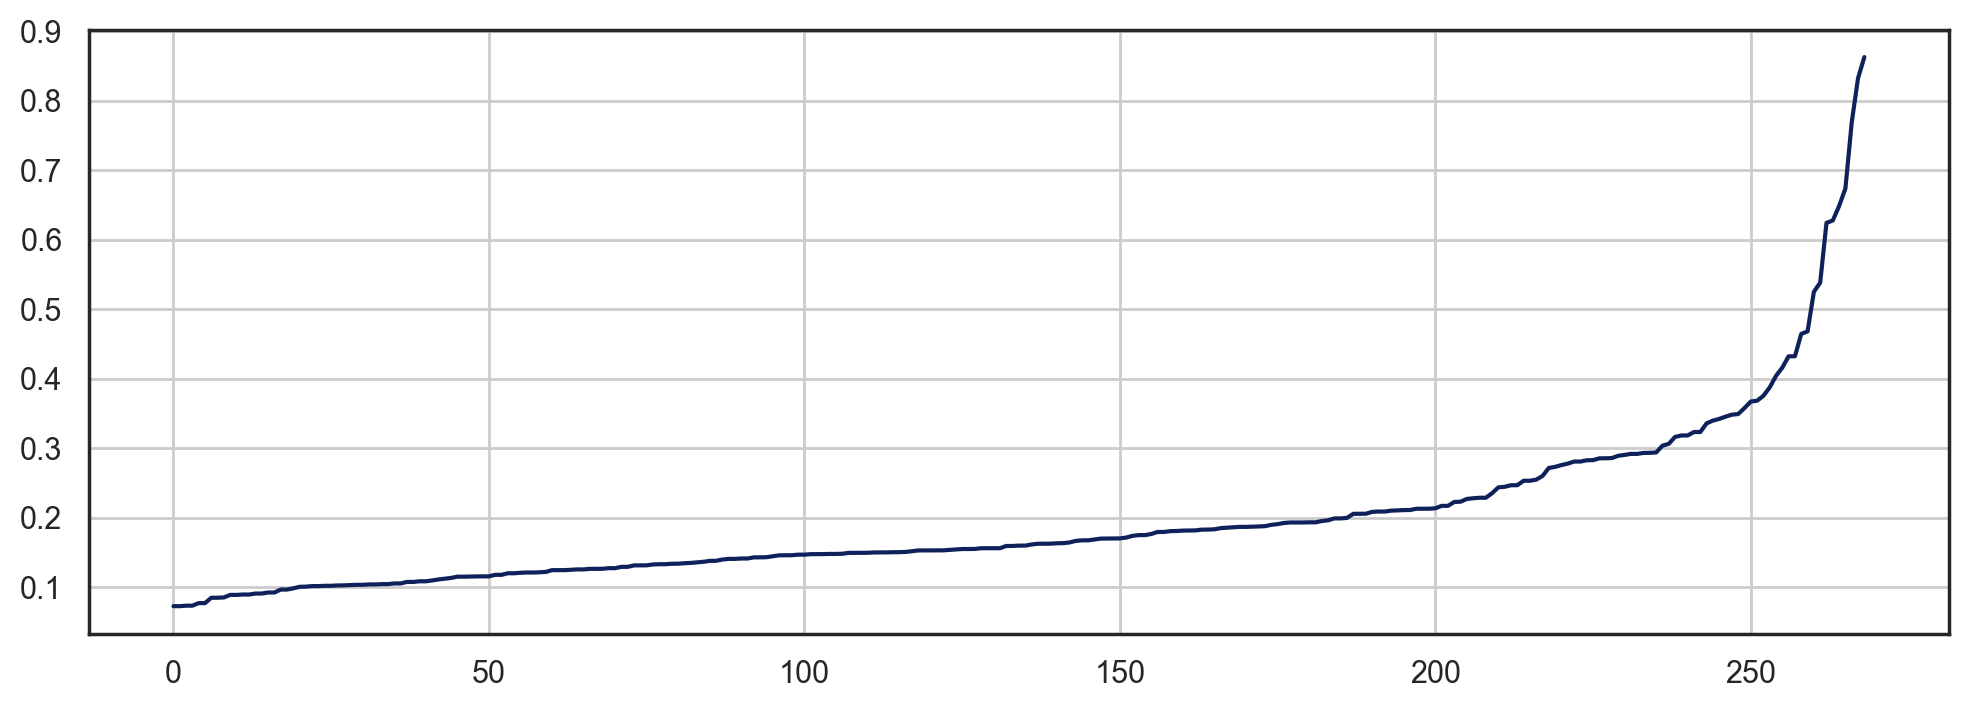

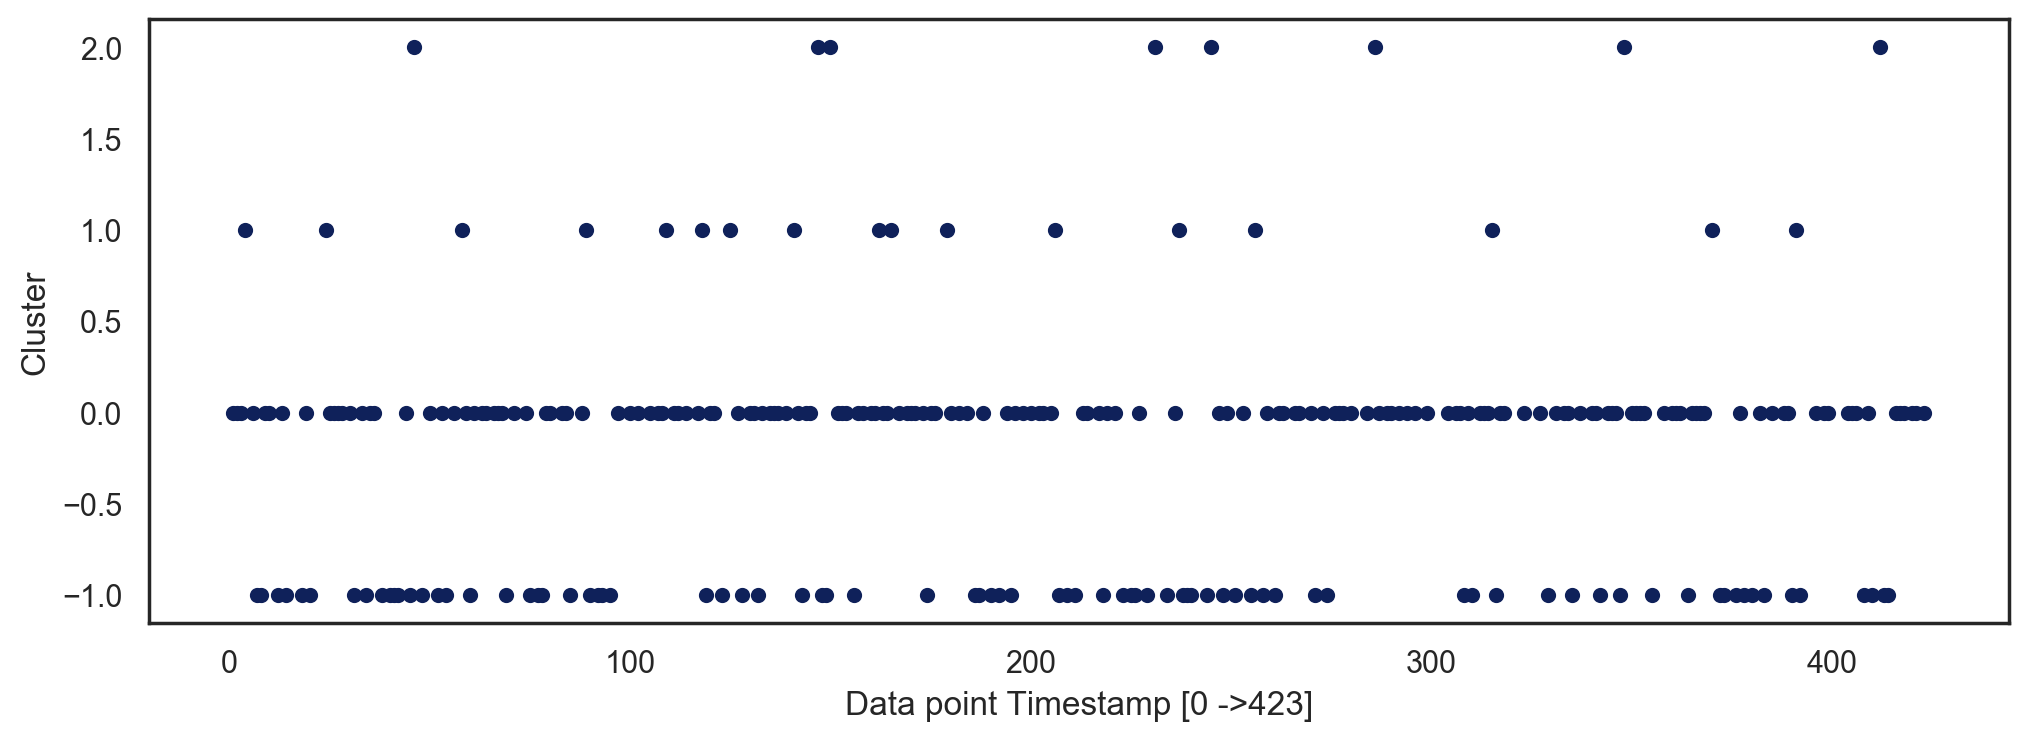

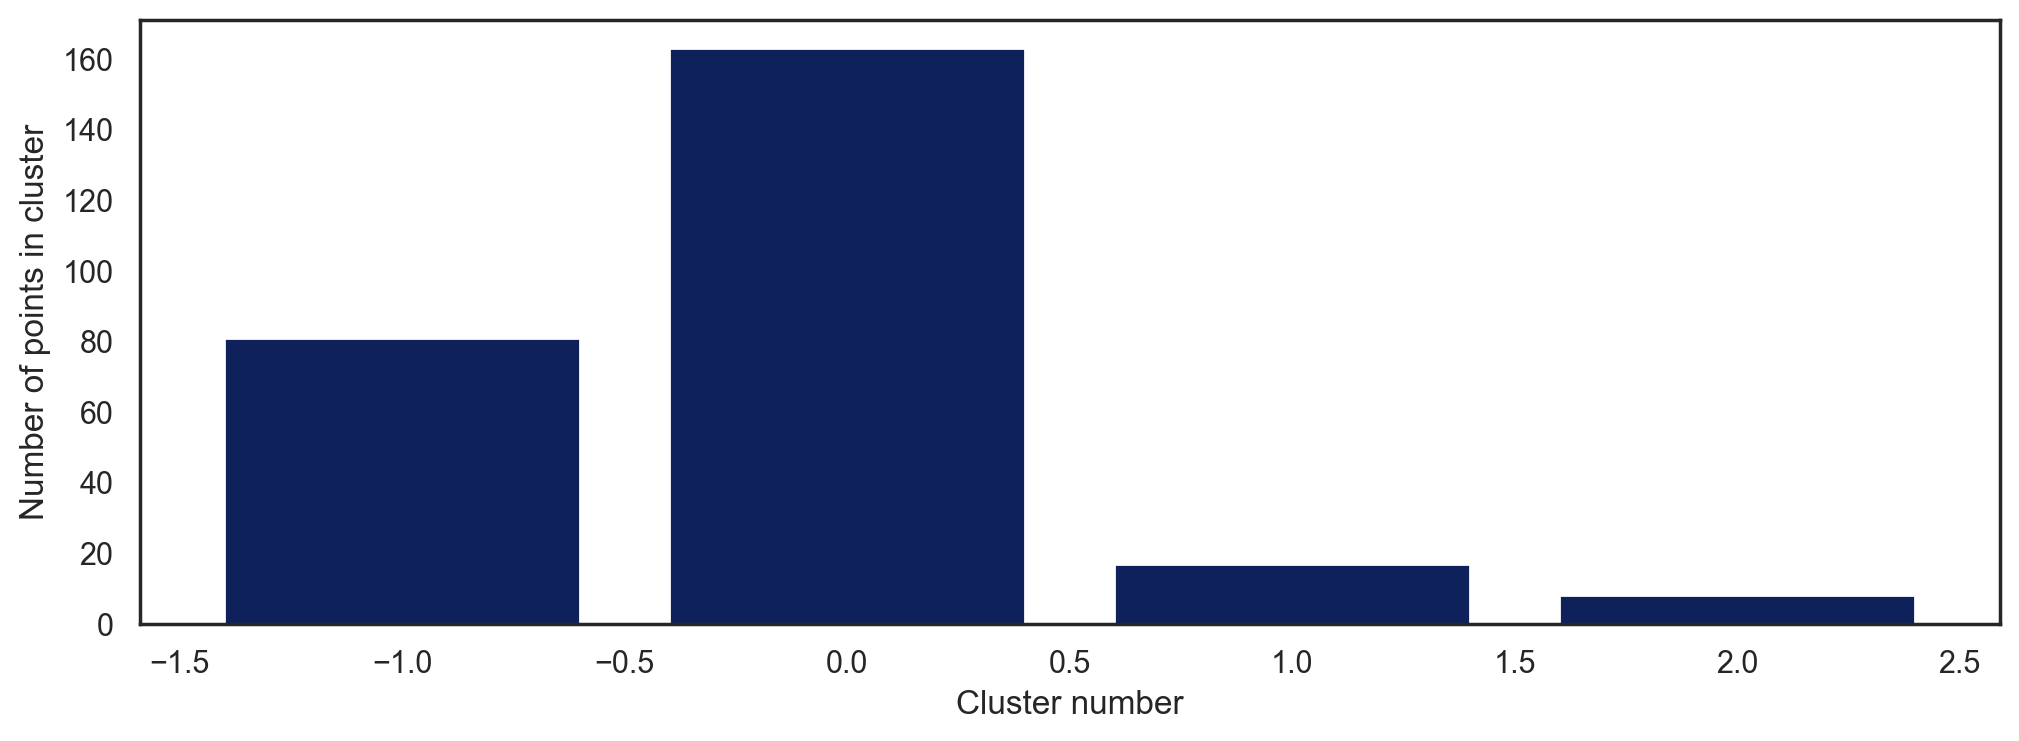

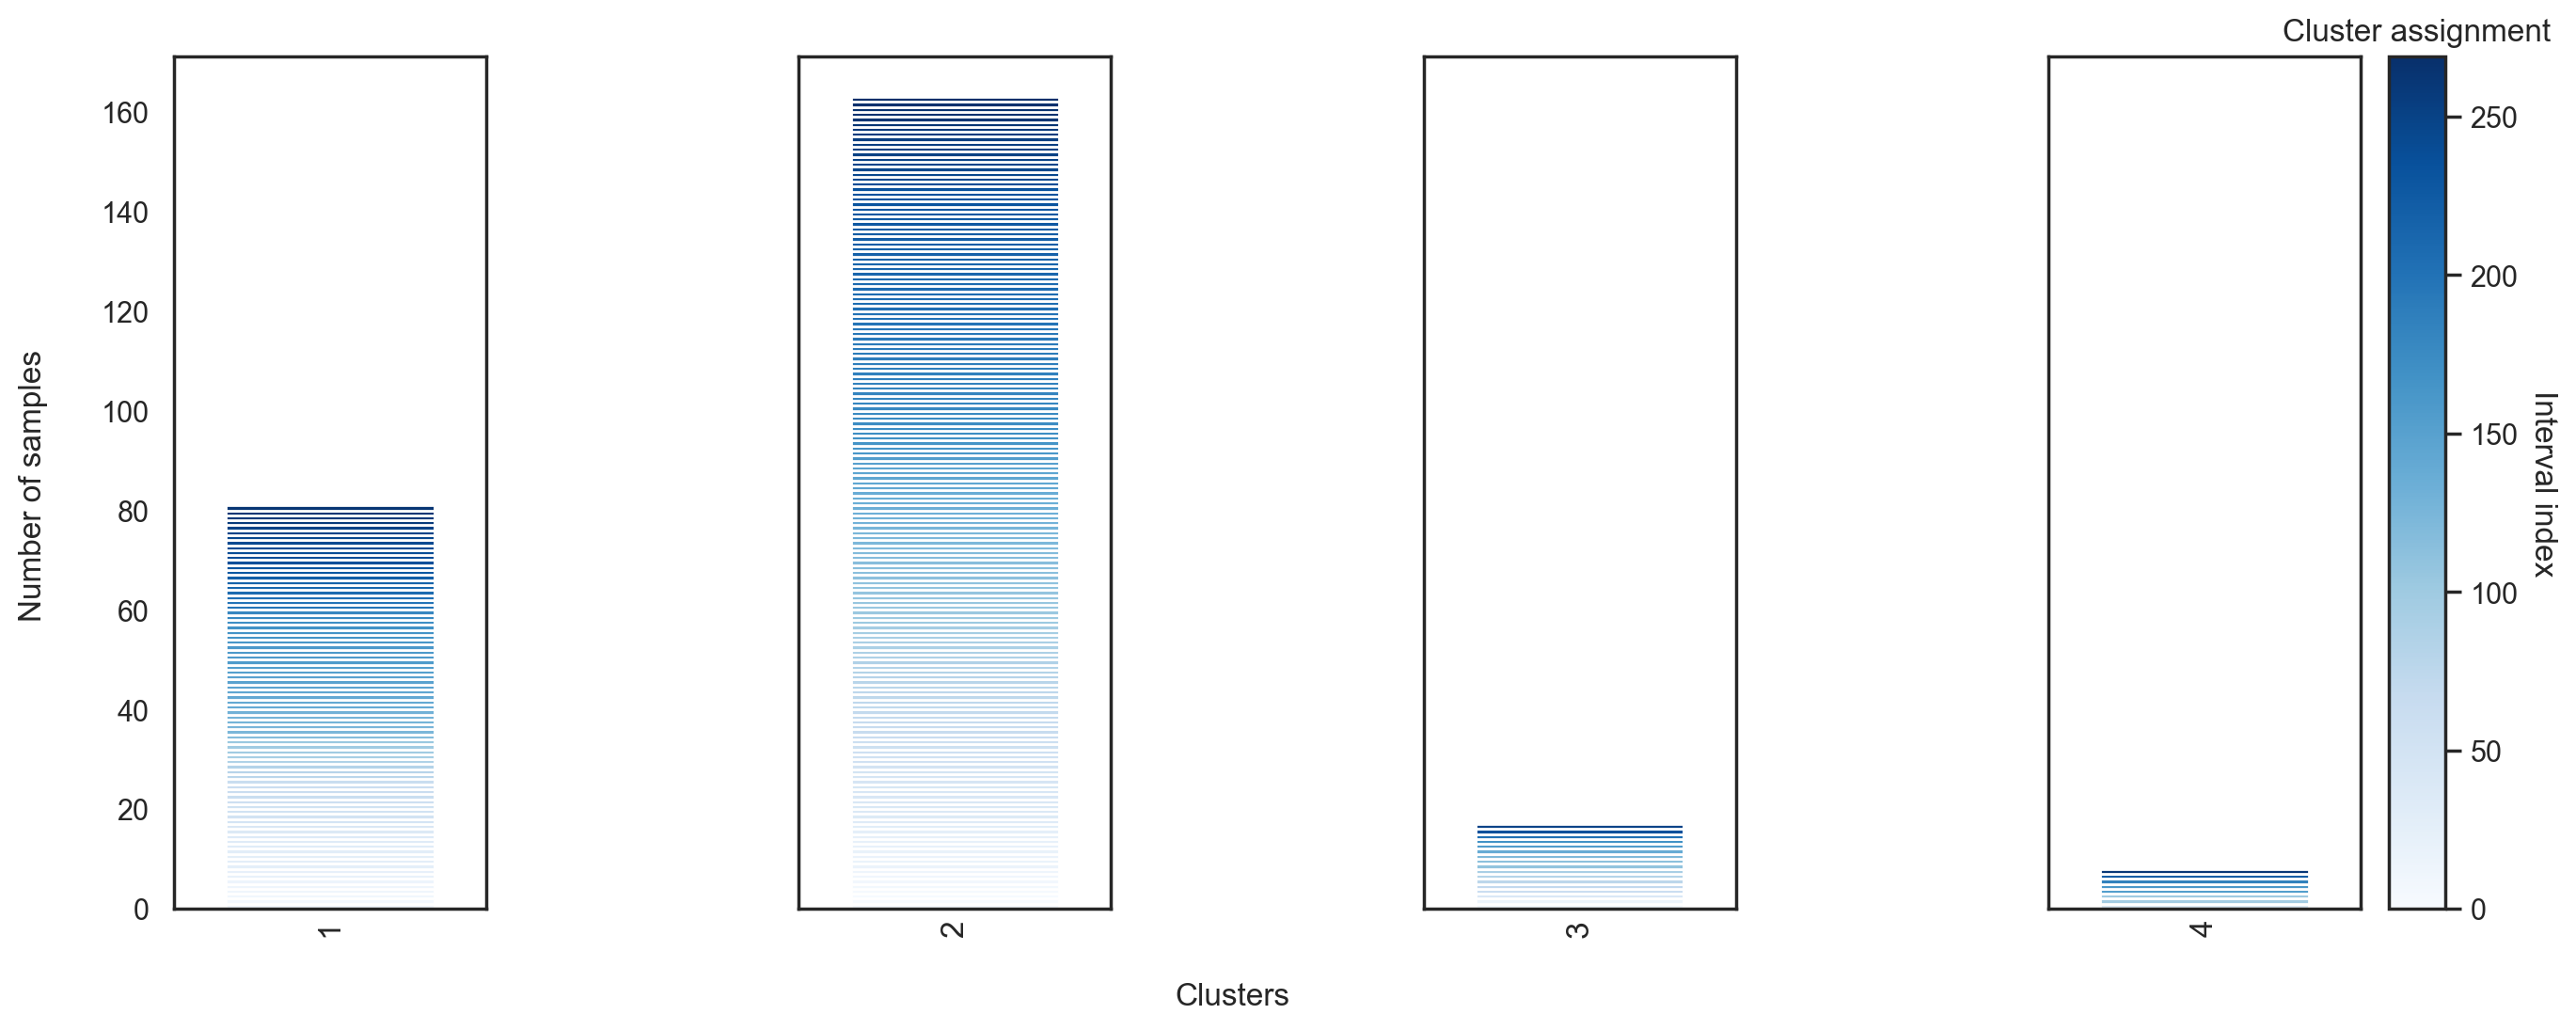

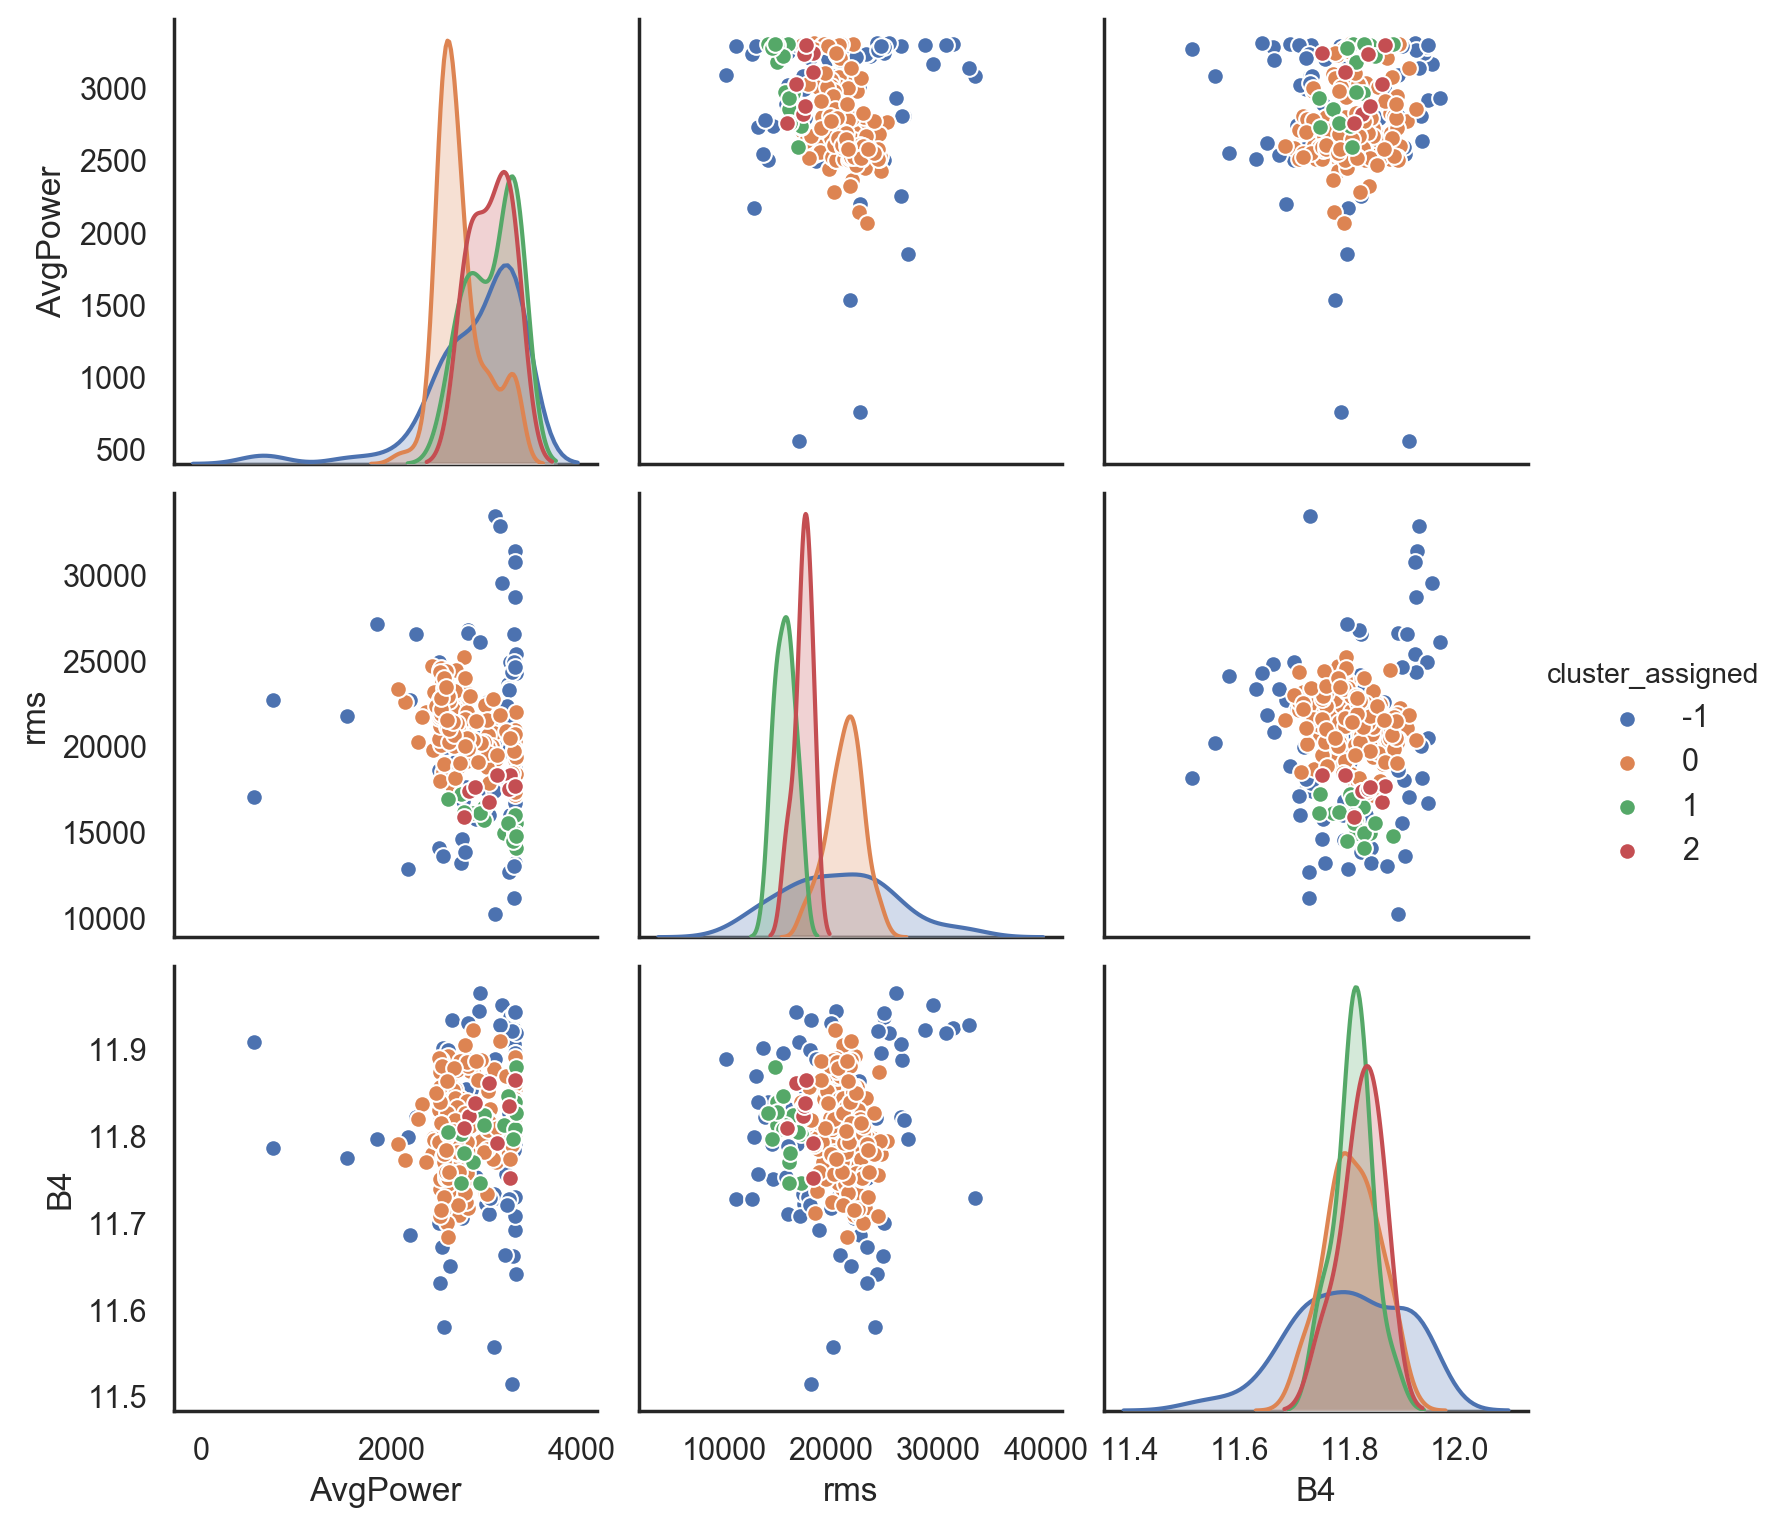

In [650]:
cluster_labels = clustering.db_scan_clustering(feature_df,'pca',eps=0.25)
clustering.plot_clusters(cluster_labels)
clustering.plot_clusters_pair_plot(feature_df, ['AvgPower','rms','B4'],cluster_labels)

In [141]:
from sklearn.decomposition import PCA
COMPS = 8
pca = PCA(n_components=COMPS)
principalComponents = pca.fit_transform(scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = [f"{i}" for i in (range(COMPS))])

In [142]:
principalDf

,0,1,2,3,4,5,6,7
0,0.141431,0.400818,0.052286,-0.004221,-0.094073,0.036855,0.013337,-0.040752
1,-0.327043,0.316536,-0.002494,-0.060586,0.063723,-0.112123,0.027307,0.052176
2,-0.278680,0.392763,0.052427,-0.117621,0.025266,-0.113873,0.018134,-0.006917
3,-0.460390,0.107781,-0.054734,-0.128105,-0.043002,-0.090076,-0.030493,-0.026086
4,0.256159,0.076732,-0.079097,0.013287,0.014386,-0.069926,-0.019782,-0.080188
...,...,...,...,...,...,...,...,...
264,0.126895,-0.481902,-0.099023,0.060904,0.006036,-0.001345,0.027512,-0.009456
265,0.212756,0.155462,0.102278,-0.110755,-0.006953,-0.036702,0.023406,0.050661
266,0.030764,-0.328100,0.091078,-0.102924,0.037518,-0.083475,0.082031,-0.018791
267,0.106358,-0.191644,-0.022766,0.102074,-0.009028,-0.091065,-0.087676,0.027370


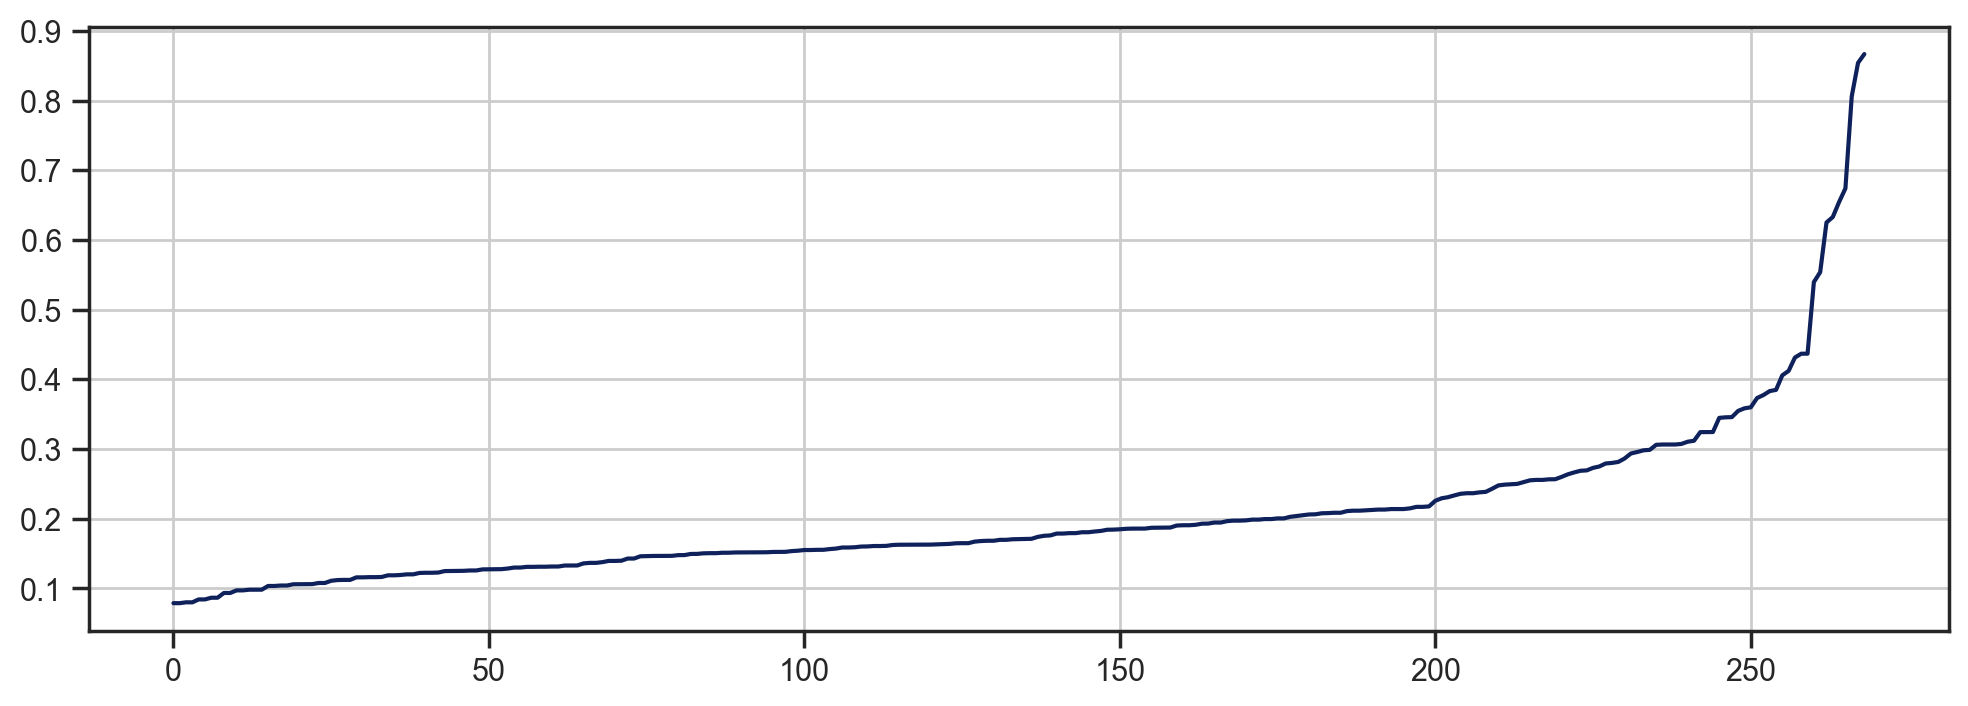

In [143]:
# optimal distance:
X_pca = principalDf.values

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances,color="#0F215A")
plt.grid(True)

In [ ]:

# Cluster it 
# df_short = df_short.drop(['NacelleDirection'],axis=1)

def db_clus(eps):
    print(eps)
    clustering = DBSCAN(eps=eps, min_samples=5).fit(principalDf)
    cluster_map = pd.DataFrame()
    cluster_map['data_index'] = res.index.values
    cluster_map['cluster'] = clustering.labels_
    cluster_map.plot.scatter(y='cluster', x='data_index',c="#0F215A")
    plt.xlabel(f'Data point Timestamp [0 ->{res.index.values.max()}]')
    plt.ylabel('Cluster')
    plt.show()
    plt.bar(cluster_map['cluster'].value_counts().keys(), cluster_map['cluster'].value_counts().values,color="#0F215A")
    plt.xlabel('Cluster number')
    plt.ylabel('Number of points in cluster')
    return cluster_map['cluster'].var(),cluster_map['cluster'].mean()
    

# Clustering with different epislons    
# db_clus(0.09) 0.096 0.106
#a = np.linspace(0.096,0.106,15)
a = np.linspace(0.08,0.3,20)
print(len(a))
varz =[]
meanz = []
for i in a:
    v,m = db_clus(i)
    varz.append(v)
    meanz.append(m)
plt.show()
plt.plot(a,varz)
plt.plot(a,meanz)

plt.show()

# PCA -> Sklearn Knn

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [ ]:
X = principalDf.values


wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
X = principalDf.values


kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
print((pred_y)) # the clusters assigned

df_assigned = pd.DataFrame(data=pred_y,columns=["Assigned cluster"])
df_assigned['index'] = np.arange(0,len(pred_y))


count = pd.Series(pred_y).value_counts().sort_index()
#plt.plot(count)

plt.scatter(df_assigned['index'],df_assigned['Assigned cluster'])
plt.show()

#plt.scatter(X[:,2], X[:,2])
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
#plt.show()
df_assigned

In [227]:
principalDf

,0,1,2,3,4,5,6,7
0,0.141431,0.400818,0.052286,-0.004221,-0.094073,0.036855,0.013337,-0.040752
1,-0.327043,0.316536,-0.002494,-0.060586,0.063723,-0.112123,0.027307,0.052176
2,-0.278680,0.392763,0.052427,-0.117621,0.025266,-0.113873,0.018134,-0.006917
3,-0.460390,0.107781,-0.054734,-0.128105,-0.043002,-0.090076,-0.030493,-0.026086
4,0.256159,0.076732,-0.079097,0.013287,0.014386,-0.069926,-0.019782,-0.080188
...,...,...,...,...,...,...,...,...
264,0.126895,-0.481902,-0.099023,0.060904,0.006036,-0.001345,0.027512,-0.009456
265,0.212756,0.155462,0.102278,-0.110755,-0.006953,-0.036702,0.023406,0.050661
266,0.030764,-0.328100,0.091078,-0.102924,0.037518,-0.083475,0.082031,-0.018791
267,0.106358,-0.191644,-0.022766,0.102074,-0.009028,-0.091065,-0.087676,0.027370


In [ ]:
print(len(X[:,1]))

# Herachnical clsutering

## Just on the PCA set

In [ ]:
from scipy.cluster.hierarchy import fcluster


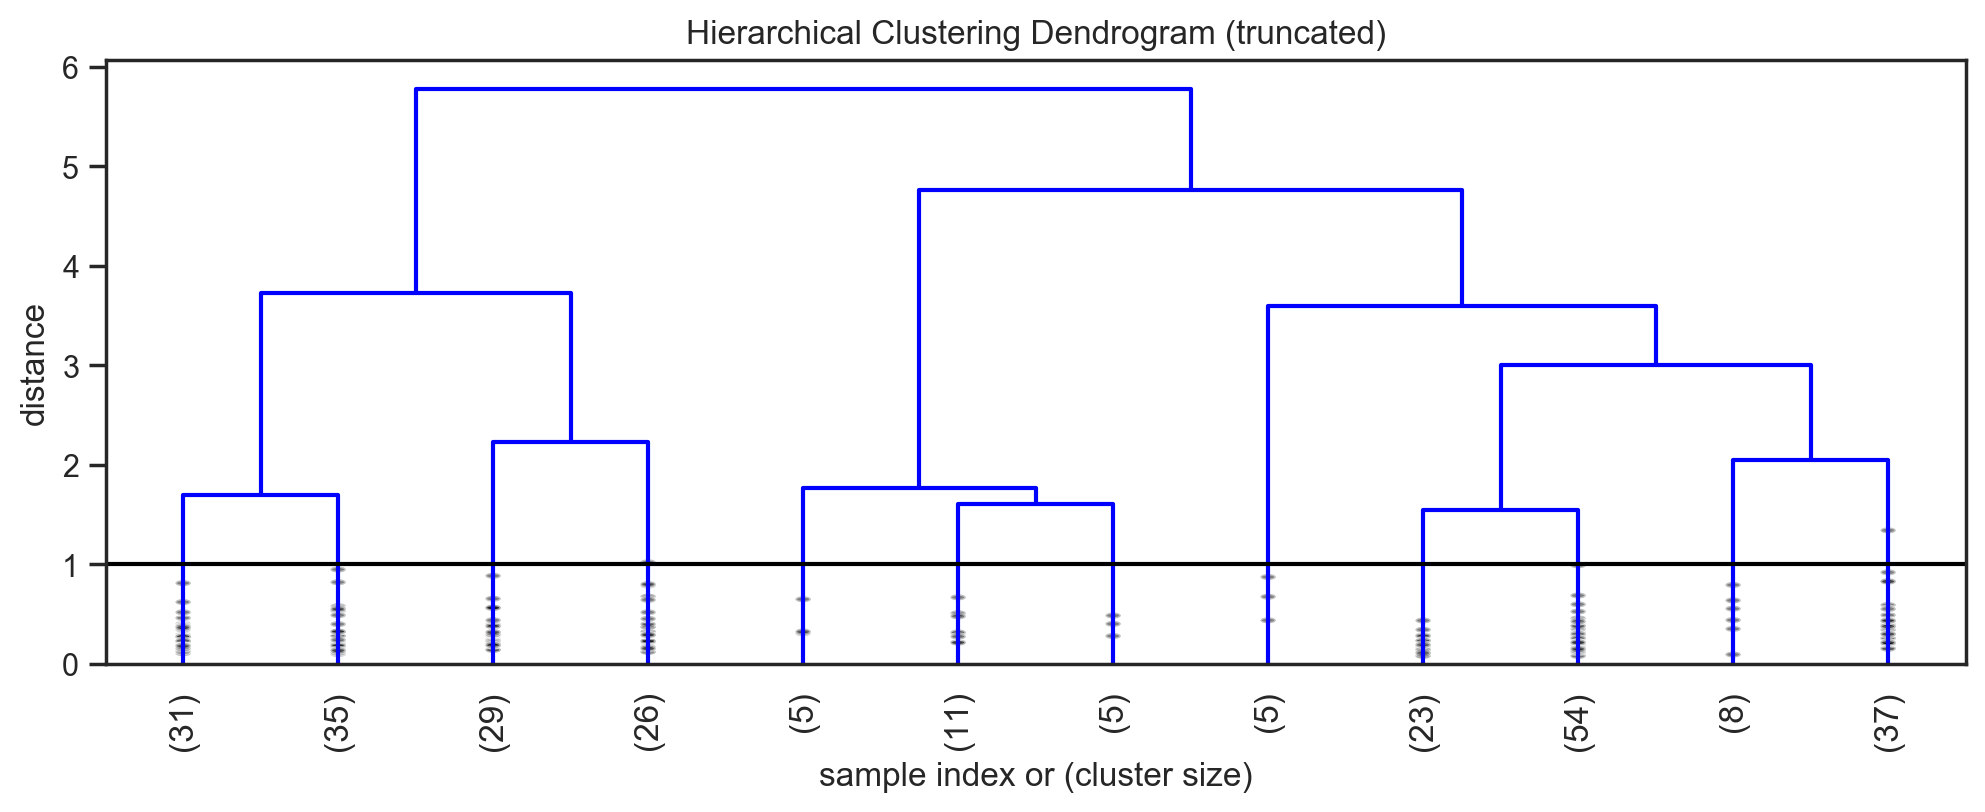

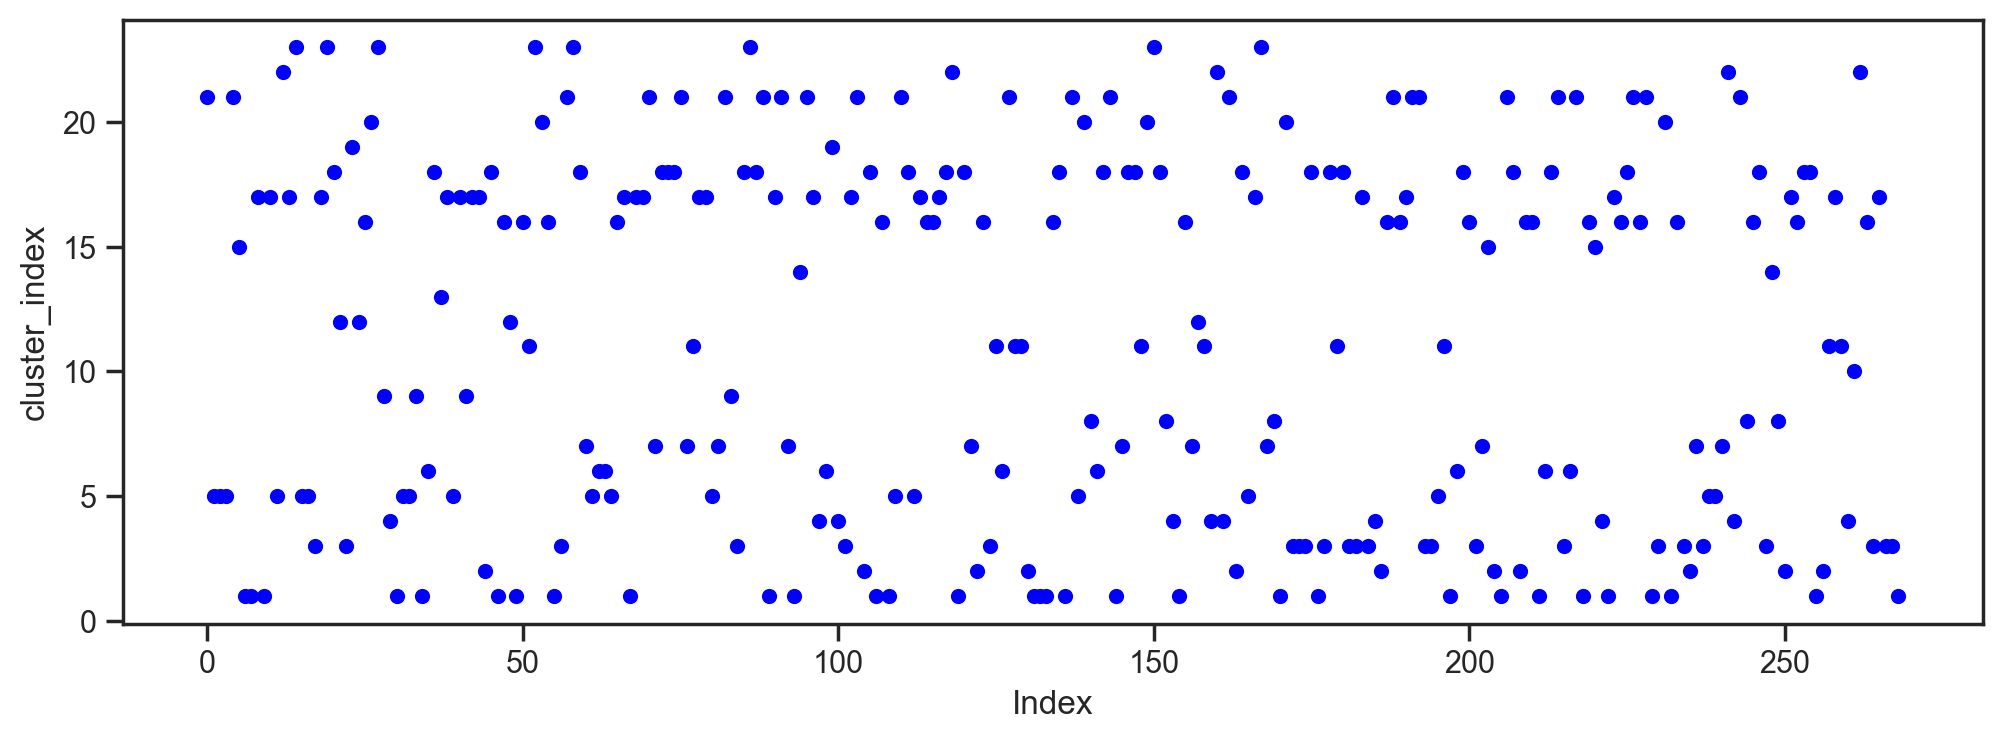

In [262]:
from scipy.cluster.hierarchy import dendrogram, linkage

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata




X = principalDf.values

# setting distance_threshold=0 ensures we compute the full tree.
#model = AgglomerativeClustering(distance_threshold=0.1, n_clusters=None)

# model = model.fit(X)
Z = linkage(X, 'ward')


fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d=1
)
plt.show()

# get the cluster indexes
from scipy.cluster.hierarchy import fcluster
max_d = 1
clusters = fcluster(Z, max_d, criterion='distance')
cf = pd.DataFrame(data = clusters)
cf['Index'] = np.arange(0,len(clusters))
cf = cf.rename(columns={0:'cluster_index'})
cf.plot.scatter(x='Index', y='cluster_index', c="Blue")

In [639]:
clustering.plot_clusters_pair_plot(feature_df, cf.cluster_index)

0      52
1       8
2       8
3       6
4      46
       ..
264    25
265    56
266    21
267    27
268    43
Name: cluster_index, Length: 269, dtype: int32

## On the original scaled set 

In [264]:
res.head()

,Index,AvgPower,ActPower,WindSpeed,NacelleDirection,AvgSpeed,rms,kurt,skewness,energy_mean,signal_mean,Power spectral entropy,B1,B2,B3,B4,B5
1,1,2697.461426,2332.100098,9.1,256.100006,1456.464986,22098.519817,6.689281,2.059123,3200.186703,82.552835,0.580794,-43398992.0,-43533.234375,-5.621581e+07,11.709023,130.643858
2,2,2606.151855,2843.500000,10.0,240.199997,1468.503663,18689.689742,6.057600,1.929951,3200.136652,70.474935,0.576439,-45124104.0,-45158.257812,-5.807831e+07,11.736296,128.927151
3,3,2541.849854,2694.100098,10.5,71.099998,1458.875183,18522.538827,5.409207,1.953700,3200.140569,68.435915,0.574164,-44672024.0,-44799.507812,-5.758532e+07,11.711760,128.878041
4,4,2853.304199,3293.399902,12.7,269.399994,1460.635409,16119.262244,4.723323,1.848180,3200.098930,60.964040,0.579481,-45195252.0,-45253.238281,-5.790530e+07,11.770350,134.833451
6,6,2752.077881,3040.300049,9.7,143.899994,1490.140485,22726.360934,5.993032,1.989390,3200.199083,85.946529,0.584168,-43321372.0,-43293.394531,-5.611709e+07,11.779746,142.769424


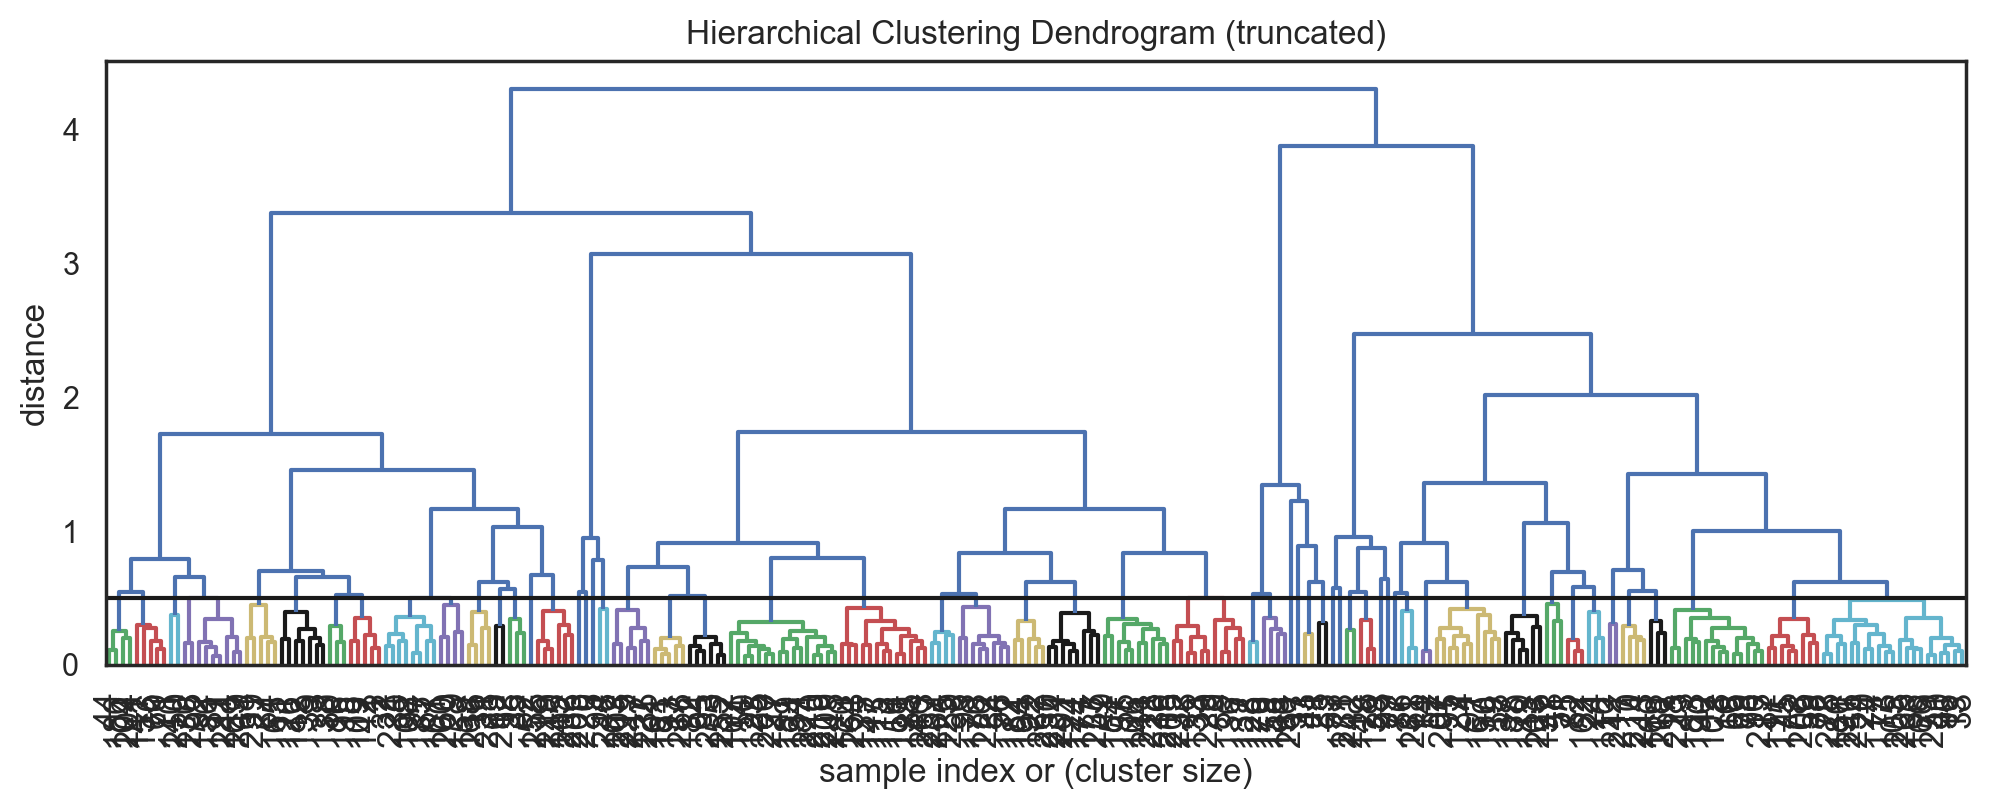

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[52  8  8  6 46 19 26 30 54 30 54  6 51 56 45  8  7 21 54 46 56 50 27 41
 50 23 40  5 34 10  9 11  9 33 30 13 29 35 56  6 56 33 54 54  1 55 30 23
 48 29 23 48 45 37 22 29 26 46 46 55  2  5 13 12  5 22 56  9 54 54 47  2
 56 56 56 49  2 44 54 56  7  4 49 34 26 24 43 55 55 30 54 46  4 26 18 46
 56  9 13 42 10 21 54 47  1 56 29 23  9  8 50 55  6 24 23 24 24 56 53 14
 24  4 20 23 28 25  6 46 31 31  4 43 30 30 23 24 30 47  6 40  3  2  8 47
 29 14 24 24 32 40 46 24 15  2 29 22  4 48 32 10 53  9 49 20 24  5 56 46
 11  4 26 38 26 28 28 55 26 28 55 32 56 21 22 54 27  9  1 23 47 23 54 56
 27 21 27  7 32 29  6 24 23 28 14 16  1 30 55 46 20 23 23 29 12 54 52 20
 11 52 29 23 17  9 26 54 23 56 47 23 29 30 28 39 30 22 28 20 14 28 11  5
 14 51 39 52  4 23 56 20 18  4  3 56 22 24 56 14  4 25 56 25 10 36 53 24
 25 56 21 27 43]


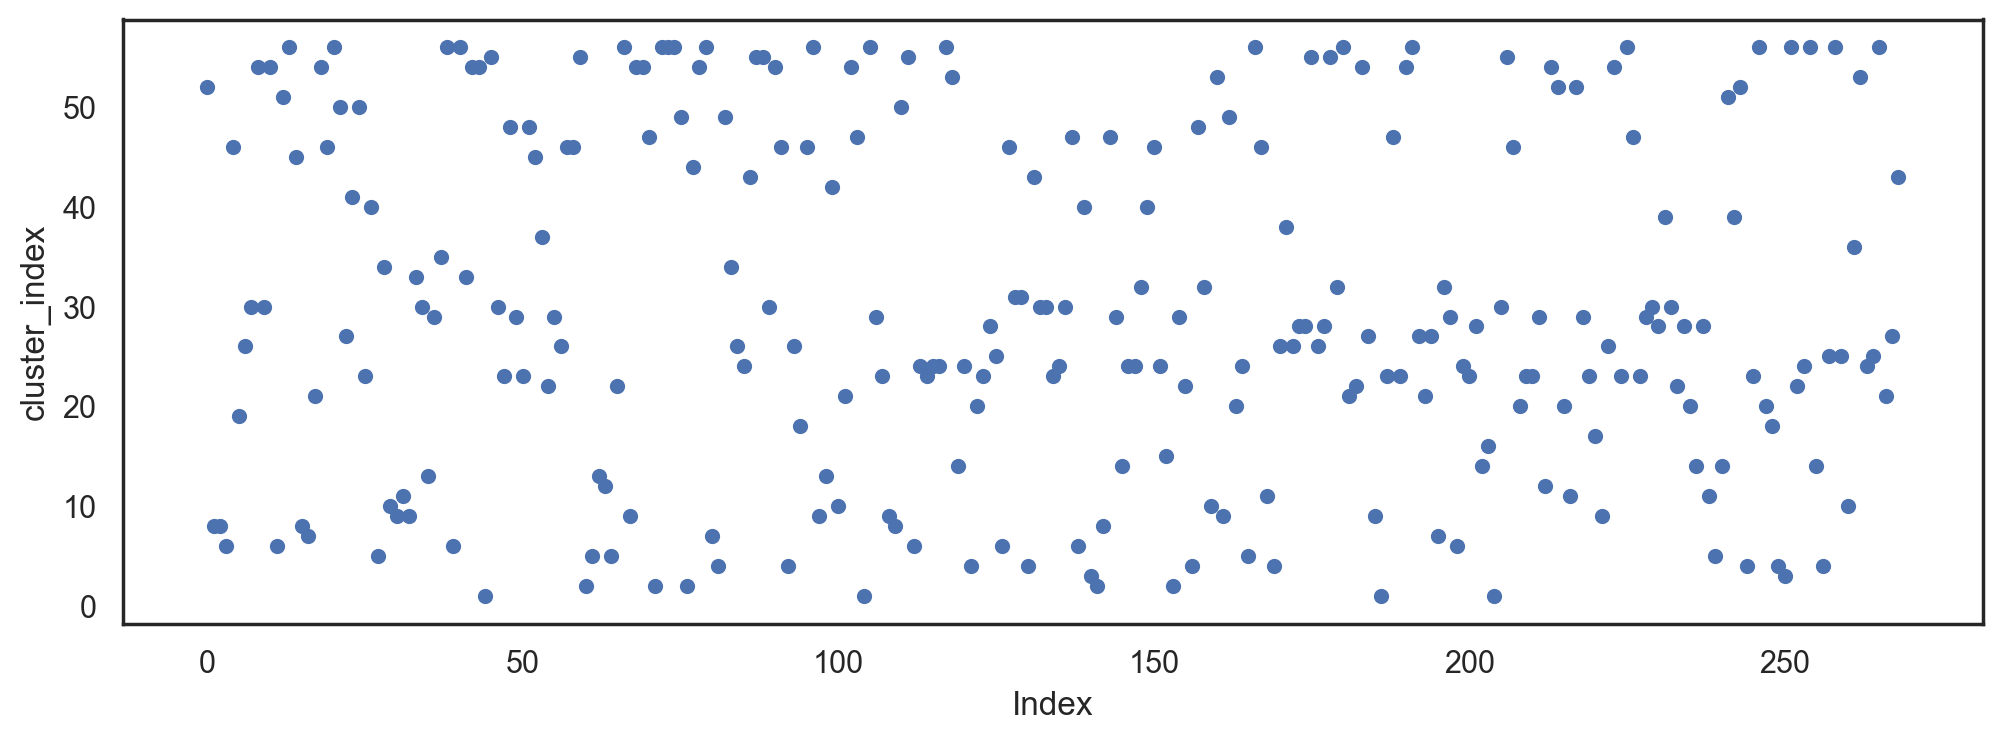

In [466]:
from sklearn.preprocessing import MinMaxScaler

cluster_df= res.drop(labels=['Index','NacelleDirection','WindSpeed','B2','B1','B3','B5'],axis=1)
scaled_rem = scale_df(cluster_df)

fancy_dendrogram(
    linkage(scaled_rem, 'ward'),
    truncate_mode='none',
    p=5,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d=0.5
)
plt.show()


# get the cluster indexes
from scipy.cluster.hierarchy import fcluster
max_d = 0.5
clusters = fcluster(linkage(scaled_rem, 'ward'), max_d, criterion='distance')
cf = pd.DataFrame(data = clusters)
cf['Index'] = np.arange(0,len(clusters))
cf = cf.rename(columns={0:'cluster_index'})
cf.plot.scatter(x='Index', y='cluster_index')



[ 1 10 10 10 13 15  9 19  3 13  3 10 18  3 17 10 10 19  3 17  3  6 11  4
  6 11  4 10 12  9  9 16 10 12 14 16 13  7  3 10  3 12  3  3  8 13 14 11
  6  9 11  0 17  4 19 13 14 17 17  1  2 10 16 16 10 11  3  9  3  3  1  2
 13  3  3  6  2 14  3  3 10  2  6 12 14 11 17 13  1 13  3 13  2  9 15 17
  3  9 16  4  8 19  3  1  8  3 13 11  9 10  6 13 10  3 11 11 11  3 18 14
  3  2 11 11 19  0 10  6  0  0  2 14 14 14 11 11 13  1 10  4  8  8 10  1
 13 14 11  8  0  4 17  3  2  9 13 11  2  6  0  9 18  9  6  8  3 10 11 17
  2  2 14  4 14 19 14 13 14 19 13  0  3 19 19  3  9  9  8 11  1 11  3  6
 13 19  9 10  0 11 10 11 11 19  2 15  8  2  1 13  8 11 11 13 16  3  1 19
 16  1 13 11 15  9 14  3 11 13  1 11 13 14  9  1  8 19  9 19  2 19 16 10
 14 18  1  1  2 11  3 19  5  2  2  3 11 19  3  9  2  0  3  0 16 12 18 11
  0  3 19 11 14]


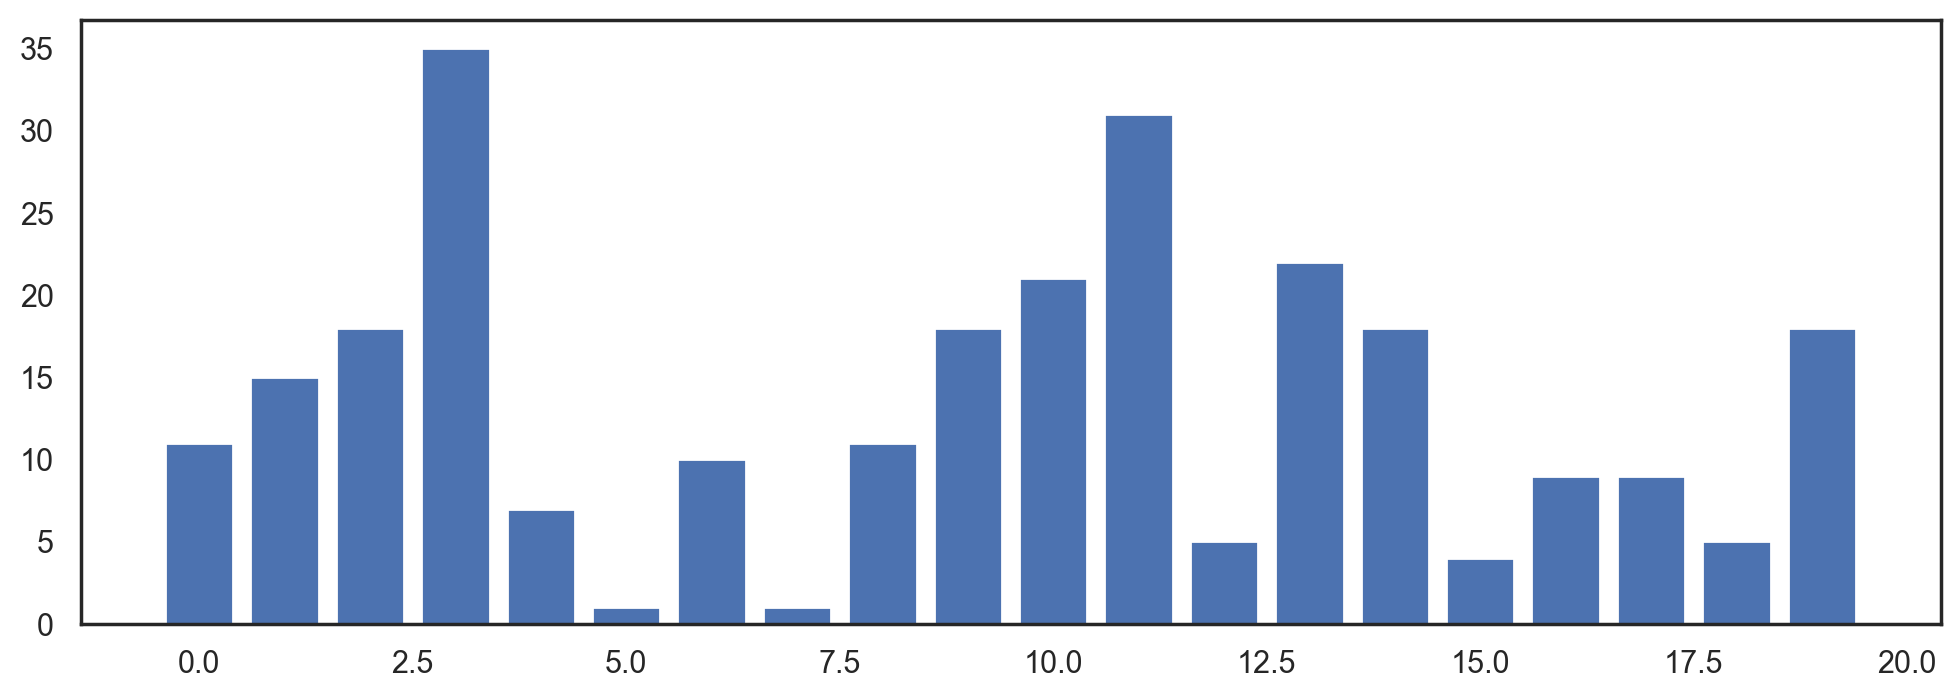

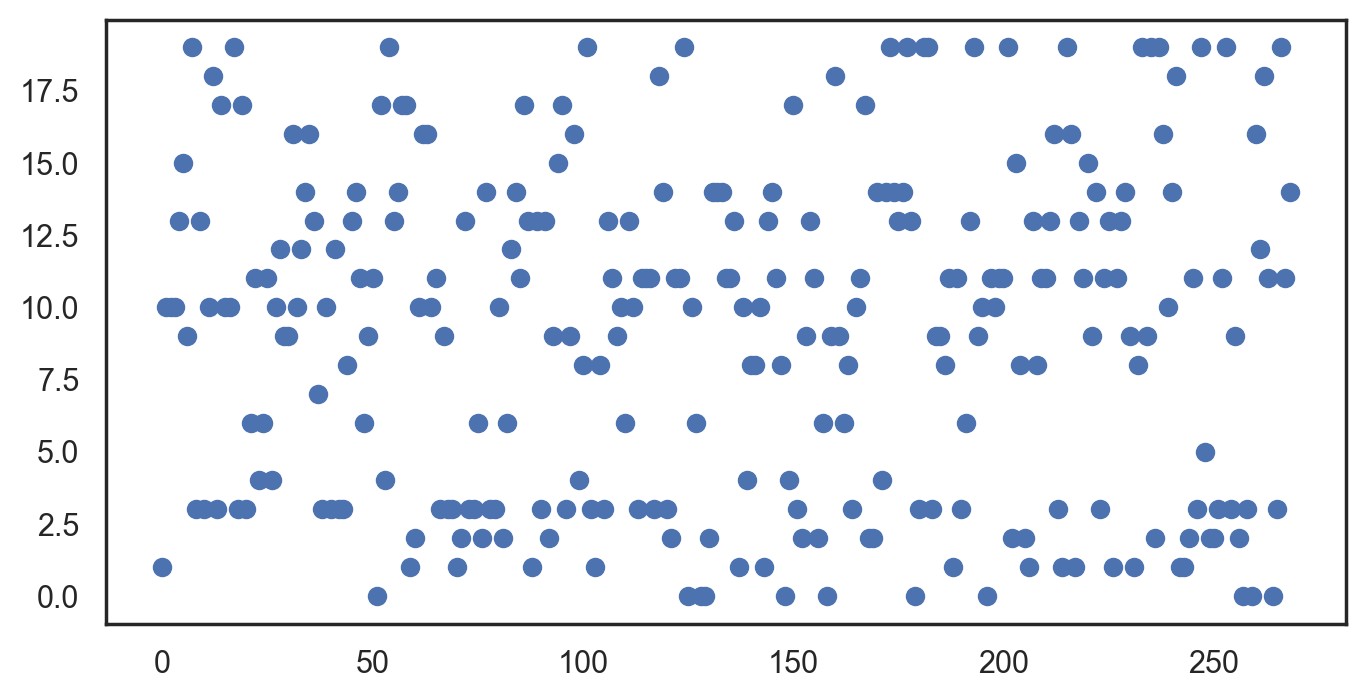

'sns.FacetGrid(data, hue="Index", size=4)    .map(plt.scatter, "sepal_length", "sepal_width")    .add_legend();'

In [478]:
# kmeans impl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import urllib.request
import random
# seaborn is a layer on top of matplotlib which has additional visualizations -
# just importing it changes the look of the standard matplotlib plots.
# the current version also shows some warnings which we'll disable.
import seaborn as sns
sns.set(style="white", color_codes=True)
import warnings
warnings.filterwarnings("ignore")


from sklearn import datasets
iris = datasets.load_iris()
cluster_df= res.drop(labels=['Index','NacelleDirection','WindSpeed','B2','B1','B3','B5'],axis=1)

X = cluster_df

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

scaler.fit(X)
X_scaled_array = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_array)

X_scaled.sample(5)


# try clustering on the 4d data and see if can reproduce the actual clusters.

# ie imagine we don't have the species labels on this data and wanted to
# divide the flowers into species. could set an arbitrary number of clusters
# and try dividing them up into similar clusters.

# we happen to know there are 3 species, so let's find 3 species and see
# if the predictions for each point matches the label in y.

from sklearn.cluster import KMeans

nclusters = 20 # this is the k in kmeans
seed = 0

km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X_scaled)

# predict the cluster for each data point
y_cluster_kmeans = km.predict(X_scaled)

print(y_cluster_kmeans)
unique, counts = np.unique(np.array(y_cluster_kmeans), return_counts=True)
plt.bar(unique, counts)
plt.show()

fig = plt.figure(figsize=(8,4))
plt.scatter(np.arange(0,len(y_cluster_kmeans)),y_cluster_kmeans)
plt.show()


# use seaborn to make scatter plot showing species for each sample
'''sns.FacetGrid(data, hue="Index", size=4) \
   .map(plt.scatter, "sepal_length", "sepal_width") \
   .add_legend();'''

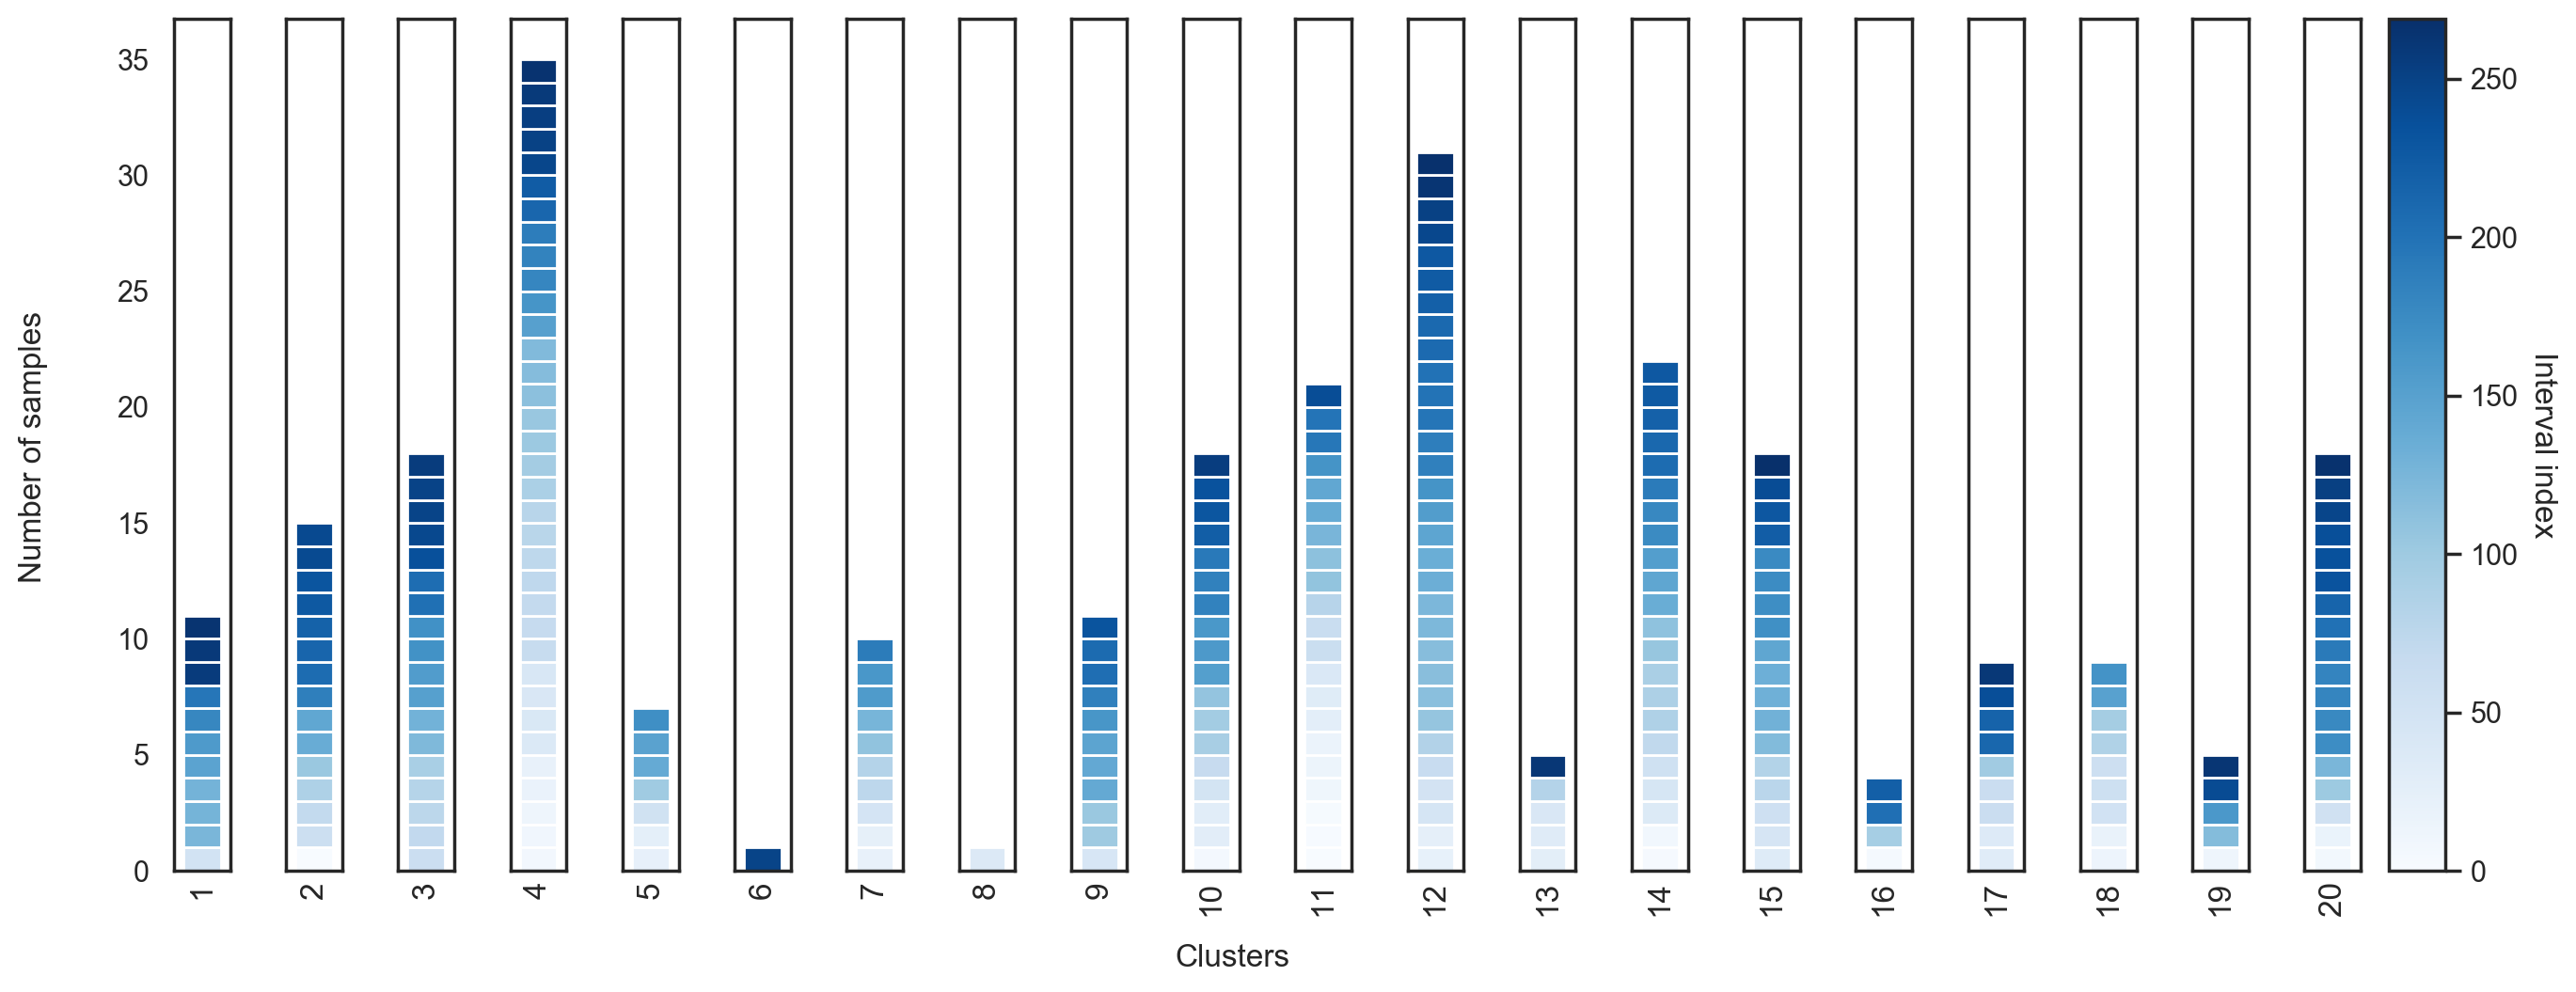

In [637]:
def plot_clusters(y_cluster_kmeans):
    '''
    y_cluster_kmeans :: List of all datapoints and which cluster they are assigned to.
    
    EXAMPLE:
    plot_clusters([1, 2, 1, 1, 1, 2, 3])
    
    '''    
    myDict = {}
    min_clus = y_cluster_kmeans.min()
    
    if not (min_clus == 0):
        y_cluster_kmeans = y_cluster_kmeans - 1
        min_clus = 0
    
    for i, elem in enumerate(y_cluster_kmeans):
        if (elem in myDict):
            myDict[elem].append(i)
        else:
            myDict[elem] = [i]
    # sorted plot matplotlib
    for i in range(min_clus,len(myDict)):
        np.sort(myDict[i])
    dfs =[]
    for i in range(min_clus,len(myDict)):
        dfs.append(pd.DataFrame.from_dict(myDict[i]))

    fig, axs = plt.subplots(1,len(myDict), figsize=(15, 6), facecolor='w', edgecolor='k',sharex=True, sharey=True)
    fig.subplots_adjust(hspace = .2, wspace=1)

    # ax.set_xticks(np.arange(len(myDict)))

    norm = plt.Normalize(0, len(y_cluster_kmeans))
    # col = plt.cm.Blues(norm(dfs[0].values))
    #dfs[0].T.plot(kind='bar',stacked=True,width=0.5,legend=False, color=col,ax=ax)
    for i in range(min_clus,len(myDict)):
        col = plt.cm.Blues(norm(dfs[i].values))
        pd.DataFrame(data=np.repeat(1,len(norm(dfs[i].values)))).T.plot(kind='bar',stacked=True,ax=axs[i],width=1,legend=False,color=col)
        axs[i].set_xticks(ticks=[])
        axs[i].set_xlabel(f"{i+1}",rotation=90)

    fig.text(0.5, 0.04, 'Clusters', ha='center')
    fig.text(0.07, 0.5, 'Number of samples', va='center', rotation='vertical')

    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
        
    cax = fig.add_axes([axs[-1].get_position().x1+0.01,axs[-1].get_position().y0,0.02,axs[-1].get_position().height])

    #plt.colorbar(sm,fraction=2.5, pad=1.5)
    cbar = plt.colorbar(sm,cax=cax)
    cbar.set_label('Interval index', rotation=270,labelpad=15)


    plt.show()
plot_clusters(y_cluster_kmeans)

#plot_clusters(np.array(cf.cluster_index.values))

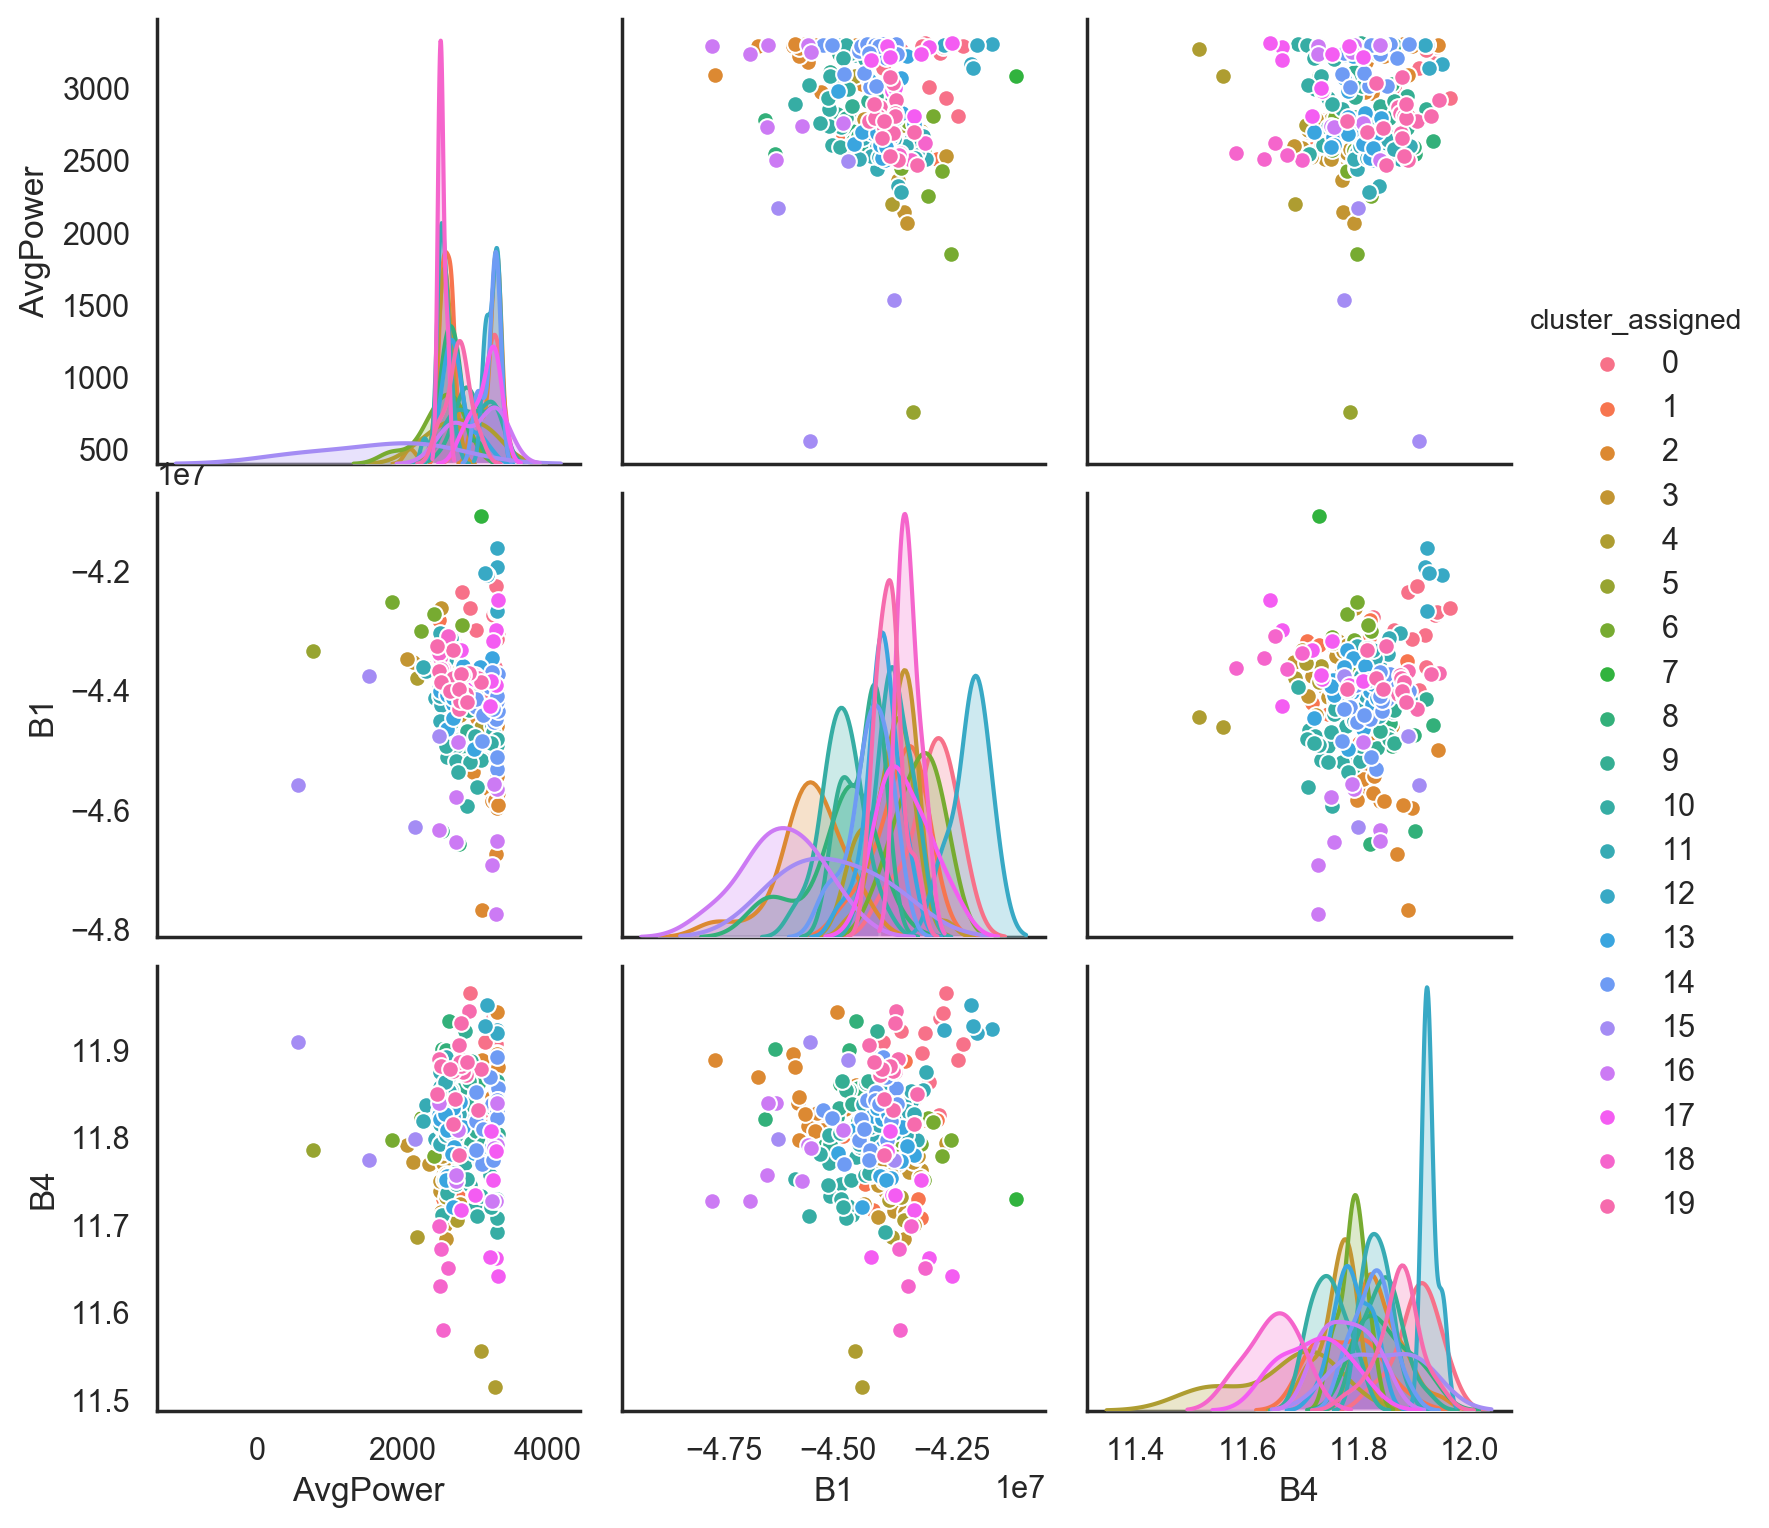

In [638]:
clustering.plot_clusters_pair_plot(feature_df, ['AvgPower','B1','B4'],y_cluster_kmeans)